# Analysis of ABF on SPAN 2.0 peaks

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from math import fabs, ceil

sns.set_style("whitegrid")
# sns.set_style("white")
import os
from tqdm.auto import tqdm
from itertools import product
import os
import pyBigWig
from math import ceil
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
PATH = os.path.expanduser('~/data/2018_chipseq_y20o20')
# BW_PATH = os.path.join(PATH, 'bw')
# COV_TYPE = 'sum'
BW_PATH = os.path.join(PATH, 'bw_span')
COV_TYPE = 'sum'
# BW_PATH = os.path.join(PATH, 'tagsbw')
# COV_TYPE = 'sum'
MODIFICATIONS = ['k4me3', 'k27ac', 'k4me1', 'k27me3', 'k36me3']
AGES = ['YD', 'OD']
REPLICATES = [f'OD{i}' for i in range(1, 30)] + [f'YD{i}' for i in range(1, 30)]

In [3]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(PATH, 'hg19.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows()
}

# Test different coverages BW

In [4]:
with pyBigWig.open(f'{PATH}/tagsbw/OD10_k27ac_hg19.bw') as bw:
    for chr, chr_size in list(CHROM_SIZES.items())[:3]:
        coverage = bw.stats(chr, exact=True, type='sum')[0]
        print(chr, chr_size, coverage, coverage / chr_size)
    print("Noise chr12:6.241.686-6.244.064", bw.stats("chr12", 6241686, 6244064, type="sum", exact=True)[0])
    print("Peak1 chr12:6.240.068-6.241.506", bw.stats("chr12", 6240068, 6241506, type="sum", exact=True)[0])
    print("Peak2 chr12:6.247.120-6.251.587", bw.stats("chr12", 6247120, 6251587, type="sum", exact=True)[0])

chr1 249250621 2579599.0 0.01034941854768739
chr2 243199373 2352977.0 0.009675094844919687
chr3 198022430 1916172.0 0.00967654017779703
Noise chr12:6.241.686-6.244.064 21.0
Peak1 chr12:6.240.068-6.241.506 207.0
Peak2 chr12:6.247.120-6.251.587 1154.0


In [5]:
with pyBigWig.open(f'{PATH}/bw_span/OD10_k27ac_hg19.bw') as bw:
    for chr, chr_size in list(CHROM_SIZES.items())[:3]:
        coverage = bw.stats(chr, exact=True, type='sum')[0]
        print(chr, chr_size, coverage, coverage / chr_size)
    print("Noise chr12:6.241.686-6.244.064", bw.stats("chr12", 6241686, 6244064, type="sum", exact=True)[0])
    print("Peak1 chr12:6.240.068-6.241.506", bw.stats("chr12", 6240068, 6241506, type="sum", exact=True)[0])
    print("Peak2 chr12:6.247.120-6.251.587", bw.stats("chr12", 6247120, 6251587, type="sum", exact=True)[0])

chr1 249250621 9104895.534871101 0.036529078637164564
chr2 243199373 8300120.831193924 0.03412887430097907
chr3 198022430 6775452.108342648 0.03421557905507294
Noise chr12:6.241.686-6.244.064 64.85167407989502
Peak1 chr12:6.240.068-6.241.506 786.6022624969482
Peak2 chr12:6.247.120-6.251.587 4776.891877651215


In [6]:
with pyBigWig.open(f'{PATH}/bw/OD10_k27ac_hg19.bw') as bw:
    for chr, chr_size in list(CHROM_SIZES.items())[:3]:
        coverage = bw.stats(chr, exact=True, type='sum')[0]
        print(chr, chr_size, coverage, coverage / chr_size)
    print("Noise chr12:6.241.686-6.244.064", bw.stats("chr12", 6241686, 6244064, type="mean", exact=True)[0])  # Mean is default
    print("Peak1 chr12:6.240.068-6.241.506", bw.stats("chr12", 6240068, 6241506, type="mean", exact=True)[0])  # Mean is default
    print("Peak2 chr12:6.247.120-6.251.587", bw.stats("chr12", 6247120, 6251587, type="mean", exact=True)[0])  # Mean is default

chr1 249250621 249678400.0 1.001716260518364
chr2 243199373 227218700.0 0.9342898264791167
chr3 198022430 184824300.0 0.9333503280411214
Noise chr12:6.241.686-6.244.064 0.8410428931875525
Peak1 chr12:6.240.068-6.241.506 14.031988873435326
Peak2 chr12:6.247.120-6.251.587 27.747257667338257


# Load BWs

In [7]:
def load_files(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        mod = next((m for m in modifications if m.lower() in f.lower()), None)
        cell = next((c for c in cells if c.lower() in f.lower()), None)
        rep = next((r for r in replicates if f'{r.lower()}_' in f.lower()), None)
        if mod and cell and rep is not None:
            df.loc[len(df)] = (os.path.join(path, f), mod, cell, rep)
    return df


In [8]:
all_bws_wo = load_files(BW_PATH, '.bw', MODIFICATIONS, AGES, REPLICATES)
print(len(all_bws_wo))
all_bws_wo.sample(3)

  0%|          | 0/191 [00:00<?, ?it/s]

191


,file,modification,cell,replicate
18,/home/jetbrains/data/2018_chipseq_y20o20/bw_sp...,k27me3,YD,YD2
101,/home/jetbrains/data/2018_chipseq_y20o20/bw_sp...,k27ac,YD,YD10
59,/home/jetbrains/data/2018_chipseq_y20o20/bw_sp...,k4me3,OD,OD12


In [9]:
# Drop outliers
OUTLIERS = {'k27ac': ['YD1', 'YD6'],
            'k27me3': ['OD9', 'YD1', 'YD2', 'YD3', 'YD4', 'YD9', 'YD10', 'YD11'],
            'k36me3': ['OD3', 'OD6', 'OD12', 'OD18', 'OD20', 'YD1', 'YD3', 'YD4', 'YD5'],
            'k4me3': ['OD6', 'OD7', 'OD14', 'YD2', 'YD3', 'YD10', 'YD14']}
outliers = [
    any(m == mo and r == ro for mo, ros in OUTLIERS.items() for ro in ros)
    for _, (m, r) in all_bws_wo[['modification', 'replicate']].iterrows()
]
print('Total outliers', sum(outliers))
all_bws = all_bws_wo[[not o for o in outliers]]
all_bws.sample(3)

Total outliers 26


,file,modification,cell,replicate
71,/home/jetbrains/data/2018_chipseq_y20o20/bw_sp...,k27me3,YD,YD18
21,/home/jetbrains/data/2018_chipseq_y20o20/bw_sp...,k4me3,YD,YD9
168,/home/jetbrains/data/2018_chipseq_y20o20/bw_sp...,k4me1,OD,OD20


# Load library coverage

In [10]:
import pyBigWig

def load_total_coverages(all_bws, covtype):
    total_coverages = {}
    input_bw_path = BW_PATH + '/input.bw'
    if os.path.exists(input_bw_path):
        try:
            with pyBigWig.open(input_bw_path) as bw:
                if covtype=='sum':
                    input_coverage = sum(
                        bw.stats(chr, exact=True, type='sum')[0] or 0.0 for chr in CHROM_SIZES.keys() if '_' not in chr)
                elif covtype=='mean':
                    input_coverage = np.average([
                        bw.stats(chr, exact=True, type='mean')[0] or 0.0 for chr in CHROM_SIZES.keys() if '_' not in chr])
                else:
                    raise f'Unsupported {covtype}'
                print('Input coverage', input_coverage)
        except Exception:
            pass
    else:
        input_coverage = np.nan

    for _, (bw_path, m, c, r) in tqdm(list(all_bws[['file', 'modification', 'cell', 'replicate']].iterrows())):
        print(bw_path)
        try:
            with pyBigWig.open(bw_path) as bw:
                if covtype == 'sum':
                    total_coverage = sum(
                        bw.stats(chr, exact=True, type='sum')[0] or 0.0 for chr in CHROM_SIZES.keys() if '_' not in chr)
                elif covtype == 'mean':
                    total_coverage = np.average([
                        bw.stats(chr, exact=True, type='mean')[0] or 0.0 for chr in CHROM_SIZES.keys() if '_' not in chr])
                else:
                    raise f'Unsupported {covtype}'
                print('Total coverage', m, c, r, total_coverage)
                total_coverages[(m, c, r)] = total_coverage
        except Exception:
            pass
            # print('ERROR')

    total_coverages_df = pd.DataFrame([(m, c, r, n) for (m, c, r), n in total_coverages.items()],
                                      columns=['modification', 'cell', 'replicate', 'total_coverage'])
    total_coverages_df['total_input'] = input_coverage
    return total_coverages_df

In [11]:
total_coverages_path = f'{PATH}/total_coverages.csv.gz'
# ! rm {total_coverages_path} || true
if os.path.exists(total_coverages_path):
    total_coverages_df = pd.read_csv(total_coverages_path, sep='\t', compression='gzip')
else:
    total_coverages_df = load_total_coverages(all_bws, covtype=COV_TYPE)
    total_coverages_df.to_csv(total_coverages_path, sep='\t', index=None, compression='gzip')
total_coverages_df.sample(3)

,modification,cell,replicate,total_coverage,total_input
37,k4me3,OD,OD3,9.976641e+07,NaN
36,k4me1,YD,YD12,9.988044e+07,NaN
160,k4me3,YD,YD18,9.977934e+07,NaN


# Peaks

In [12]:
CONSENSUS_PEAKS = {
    m: f'{PATH}/{m}_consensus_union25%.bed' for m in MODIFICATIONS
}
for m in MODIFICATIONS:
    ! wc -l {CONSENSUS_PEAKS[m]}
    pass

17297 /home/jetbrains/data/2018_chipseq_y20o20/k4me3_consensus_union25%.bed
29334 /home/jetbrains/data/2018_chipseq_y20o20/k27ac_consensus_union25%.bed
62050 /home/jetbrains/data/2018_chipseq_y20o20/k4me1_consensus_union25%.bed
10367 /home/jetbrains/data/2018_chipseq_y20o20/k27me3_consensus_union25%.bed
21340 /home/jetbrains/data/2018_chipseq_y20o20/k36me3_consensus_union25%.bed


# Load signal profiles

Previously we used `bigWigAverageOverBed`,
which compute average score of big wig over each bed.

In [13]:
def load_signal_peaks_profile(bw_df, peaks_map, covtype,
                              peaks=1000,
                              load_control=False,
                              load_profile=False,
                              load_centered=False,
                              load_profile_control=False,
                              load_centered_control=False,
                              bins=20, d=5000):
    rows = []
    for _, (bwfile, mod, cell, rep) in (
            tqdm(list(bw_df[['file', 'modification', 'cell', 'replicate']].iterrows()))):
        # We shouldn't read from it if control is not loaded
        control_bwfile = os.path.join(BW_PATH, 'input.bw') if load_control or load_profile_control or load_centered_control else bwfile
        peaksfile = peaks_map[mod]
        print(mod, cell, rep, covtype, peaksfile, bwfile)
        # Load peaks file and sort by score
        peaks_df = pd.read_csv(peaksfile, sep='\t', header=None)
        if not os.path.exists(bwfile):
            continue
        try:
            with pyBigWig.open(bwfile) as bw:
                with pyBigWig.open(control_bwfile) as bw_control:
                    for _, row in peaks_df.head(peaks).iterrows():
                        chr, start, end = row[0], row[1], row[2]
                        # print(chr, start, end)
                        if load_profile:
                            profile = bw.stats(chr, start, end, nBins=bins, type=covtype, exact=True)
                            profile = np.nan_to_num(profile, copy=False)
                            profile = np.array([0.0 if x is None else x for x in profile])
                            coverage = sum(profile)
                        else:
                            coverage = bw.stats(chr, start, end, type=covtype, exact=True)[0] or 0.0
                        if load_profile_control:
                            profile_control = bw_control.stats(chr, start, end, nBins=bins, type=covtype, exact=True)
                            profile_control = np.nan_to_num(profile_control, copy=False)
                            profile_control = np.array([0.0 if x is None else x for x in profile_control])
                            coverage_control = sum(profile_control)
                        else:
                            coverage_control = \
                                bw_control.stats(chr, start, end, type=covtype, exact=True)[0] or 0.0 if load_control else None
                        center = int((start + end) / 2)
                        if load_centered:
                            profile_centered = bw.stats(chr, max(0, center - d), center + d, nBins=bins, type=covtype, exact=True)
                            profile_centered = np.nan_to_num(profile_centered, copy=False)
                            profile_centered = np.array([0.0 if x is None else x for x in profile_centered])
                        if load_centered_control:
                            profile_control_centered = \
                                bw_control.stats(chr, max(0, center - d), center + d, nBins=bins, type=covtype,exact=True)
                            profile_control_centered = np.nan_to_num(profile_control_centered, copy=False)
                            profile_control_centered = np.array([0.0 if x is None else x for x in profile_control_centered])
                        row = [mod, cell, rep, f'{chr}:{start}-{end}', end - start, coverage]
                        if load_control:
                            row.append(coverage_control)
                        if load_profile:
                            row.extend(profile)
                        if load_profile_control:
                            row.extend(profile_control)
                        if load_centered:
                            row.extend(profile_centered)
                        if load_centered_control:
                            row.extend(profile_control_centered)
                        rows.append(row)
        except RuntimeError:
            print('Error')
            pass  # Ignore broken profiles
        except Exception:
            print('Error')
            pass  # Ignore broken profiles

    columns = ['modification', 'cell', 'replicate', 'peak', 'length', 'coverage']
    if load_control:
        columns.append('input_coverage')
    if load_profile:
        columns.extend([f'p_{i}' for i in range(bins)])
    if load_profile_control:
        columns.extend([f'ip_{i}' for i in range(bins)])
    if load_centered:
        columns.extend([f'pc_{i}' for i in range(bins)])
    if load_centered_control:
        columns.extend([f'ipc_{i}' for i in range(bins)])
    return pd.DataFrame(columns=columns, data=rows)

# Coverage

In [15]:
all_bws_profiles = load_signal_peaks_profile(
    all_bws, CONSENSUS_PEAKS, peaks=100, covtype=COV_TYPE,
    # load_profile=True, load_profile_control=True, load_centered=True, load_centered_control=True,
    load_profile=True, load_centered=True
)
all_bws_profiles.sample(2)

  0%|          | 0/165 [00:00<?, ?it/s]

k4me1 YD YD15 sum /home/jetbrains/data/2018_chipseq_y20o20/k4me1_consensus_union25%.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/YD15_k4me1_hg19.bw
k4me1 OD OD16 sum /home/jetbrains/data/2018_chipseq_y20o20/k4me1_consensus_union25%.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/OD16_k4me1_hg19.bw
k27ac YD YD20 sum /home/jetbrains/data/2018_chipseq_y20o20/k27ac_consensus_union25%.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/YD20_k27ac_hg19.bw
k4me1 OD OD4 sum /home/jetbrains/data/2018_chipseq_y20o20/k4me1_consensus_union25%.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/OD4_k4me1_hg19.bw
k4me3 YD YD19 sum /home/jetbrains/data/2018_chipseq_y20o20/k4me3_consensus_union25%.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/YD19_k4me3_hg19.bw
k36me3 YD YD6 sum /home/jetbrains/data/2018_chipseq_y20o20/k36me3_consensus_union25%.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/YD6_k36me3_hg19.bw
k27me3 OD OD20 sum /home/jetbrains/data/2018_chipseq_y20o20/k27me

,modification,cell,replicate,peak,length,coverage,p_0,p_1,p_2,p_3,...,pc_10,pc_11,pc_12,pc_13,pc_14,pc_15,pc_16,pc_17,pc_18,pc_19
12662,k27ac,OD,OD18,chr1:2513000-2518370,5370,1530.077421,66.175391,55.572704,37.292210,29.736272,...,88.812738,163.915107,323.107741,418.318663,145.939282,47.833961,25.288018,20.413219,6.550511,17.366470
9471,k4me1,YD,YD20,chr1:2105760-2106290,530,117.094080,4.695804,5.659046,6.261072,6.501882,...,101.591906,13.545588,12.040522,0.752533,11.287990,0.000000,9.782924,11.287990,9.030392,6.020261


In [16]:
def plot_split(df, value, name, average):
    if average:
        t = df[['modification', 'cell', 'replicate', value]].groupby(
            ['modification', 'cell', 'replicate']).mean().reset_index()
    else:
        t = df
    plt.figure(figsize=(4, 2.5))
    ax = plt.axes()
    sns.boxplot(data=t, x='modification', y=value, hue='cell',
                order=MODIFICATIONS,
                hue_order=['YD', 'OD'], palette={'YD': 'red', 'OD': 'blue'},
                showfliers=not average,
                ax=ax)
    if average:
        sns.swarmplot(data=t, x='modification', y=value, hue='cell',
                      dodge=True,
                      color='black', size=2,
                      order=MODIFICATIONS,
                      ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(name)
    plt.tight_layout()
    plt.show()


Signal


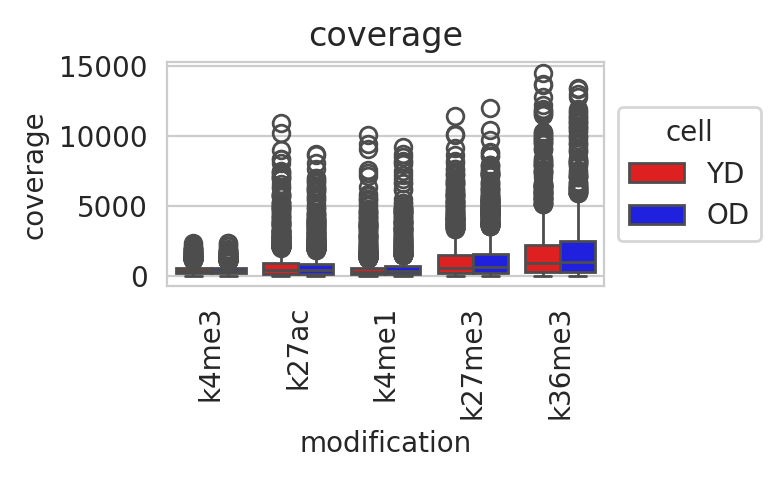

In [17]:
print('Signal')
plot_split(all_bws_profiles, 'coverage', 'coverage', False)

# RPM

In [18]:
all_bws_profiles_rpm = all_bws_profiles.merge(total_coverages_df, on=['modification', 'cell', 'replicate'])

In [19]:
all_bws_profiles_rpm['rpm'] = all_bws_profiles_rpm['coverage'] / (all_bws_profiles_rpm['total_coverage'] / 1e6)

for c in [f'p_{i}' for i in range(20)]:
    all_bws_profiles_rpm[f'rpm_{c}'] = all_bws_profiles_rpm[c] / (all_bws_profiles_rpm['total_coverage'] / 1e6)
for c in [f'pc_{i}' for i in range(20)]:
    all_bws_profiles_rpm[f'rpm_{c}'] = all_bws_profiles_rpm[c]  / (all_bws_profiles_rpm['total_coverage'] / 1e6)

Signal


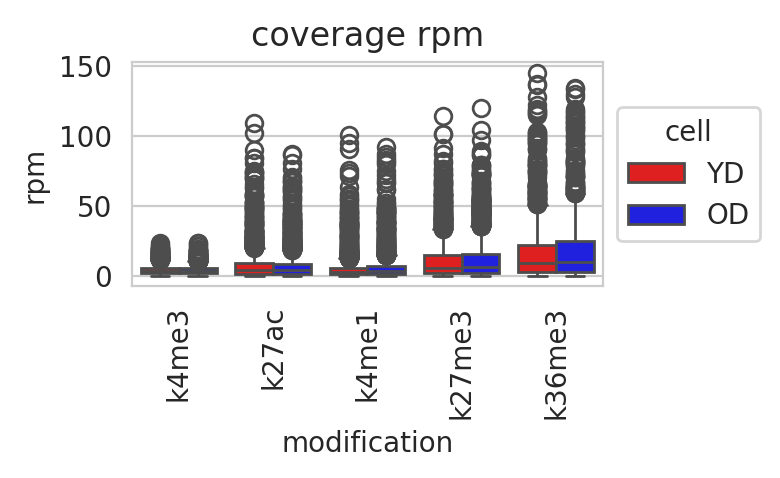

In [20]:
print('Signal')
plot_split(all_bws_profiles_rpm, 'rpm', 'coverage rpm', False)

# Profiles

Signal RPM


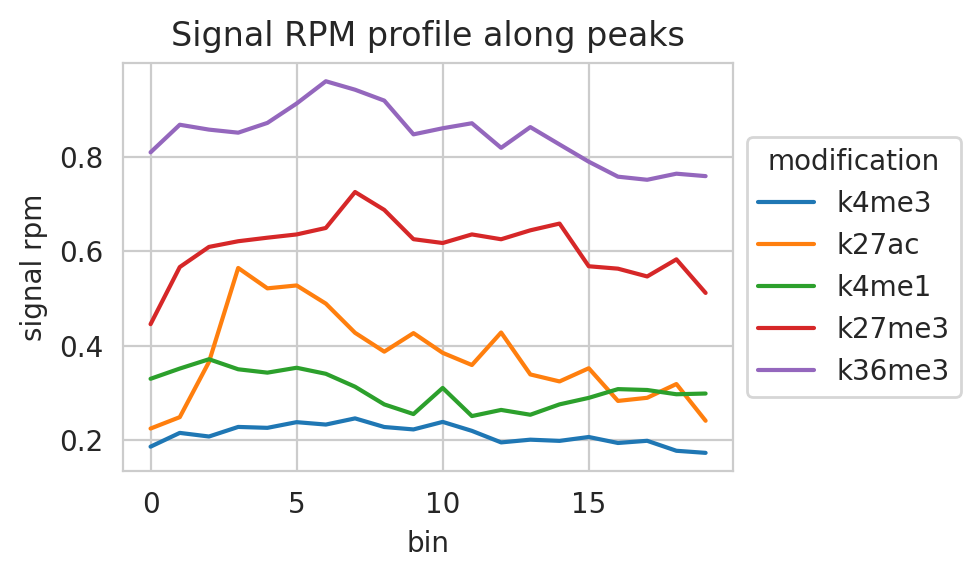

In [21]:
print('Signal RPM')
plt.figure(figsize=(5, 3))
ax = plt.axes()
# Show aggregated data, since we don't want error plots
t = all_bws_profiles_rpm[['modification'] + [f'rpm_p_{i}' for i in range(20)]].groupby(['modification']).mean().reset_index()
t.rename({f'rpm_p_{i}': i for i in range(20)}, axis=1, inplace=True)
t = pd.melt(t, id_vars=['modification'])
sns.lineplot(data=t, x="variable", y="value", hue="modification", err_style=None,
             hue_order=MODIFICATIONS, ax=ax)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('bin')
ax.set_ylabel('signal rpm')
ax.set_title('Signal RPM profile along peaks')
# ax.set_xticks([], minor=False)
# ax.set_xticklabels([])
plt.tight_layout()
plt.show()

Signal RPM


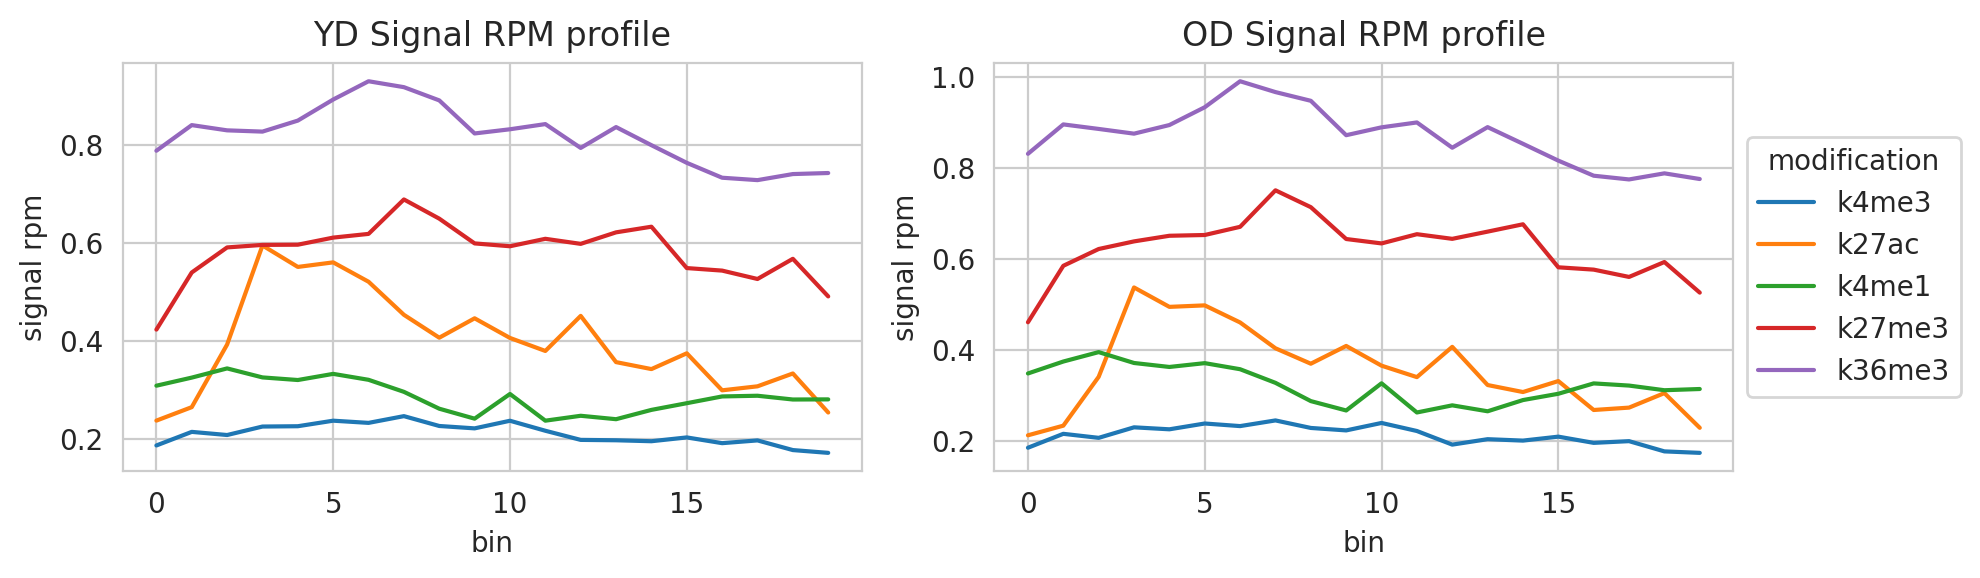

In [22]:
print('Signal RPM')
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, a in enumerate(AGES):
    ax = axs[i]
    # Show aggregated data, since we don't want error plots
    t = all_bws_profiles_rpm[all_bws_profiles_rpm['cell'] == a][
        ['modification'] + [f'rpm_p_{i}' for i in range(20)]
    ].groupby(['modification']).mean().reset_index()
    t.rename({f'rpm_p_{i}': i for i in range(20)}, axis=1, inplace=True)
    t = pd.melt(t, id_vars=['modification'])
    sns.lineplot(data=t, x="variable", y="value", hue="modification", err_style=None,
                 hue_order=MODIFICATIONS, ax=ax)

    ax.set_xlabel('bin')
    ax.set_ylabel('signal rpm')
    ax.set_title(f'{a} Signal RPM profile')
    if i == len(axs) - 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
# ax.set_xticks([], minor=False)
# ax.set_xticklabels([])
plt.tight_layout()
plt.show()

In [23]:
# print('Control')
# plt.figure(figsize=(5, 3))
# ax = plt.axes()
# # Show aggregated data, since we don't want error plots
# t = all_bws_profiles_rpm[['modification'] + [f'ip_{i}' for i in range(20)]].groupby(['modification']).mean().reset_index()
# t.rename({f'ip_{i}': i for i in range(20)}, axis=1, inplace=True)
# t = pd.melt(t, id_vars=['modification'])
# sns.lineplot(data=t, x="variable", y="value", hue="modification", err_style=None,
#              hue_order=MODIFICATIONS,
#              ax=ax)
# sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_xlabel('bin')
# ax.set_ylabel('control coverage')
# ax.set_title('Control profile along peaks')
# plt.tight_layout()
# plt.show()


# Centered profiles

Signal RPM


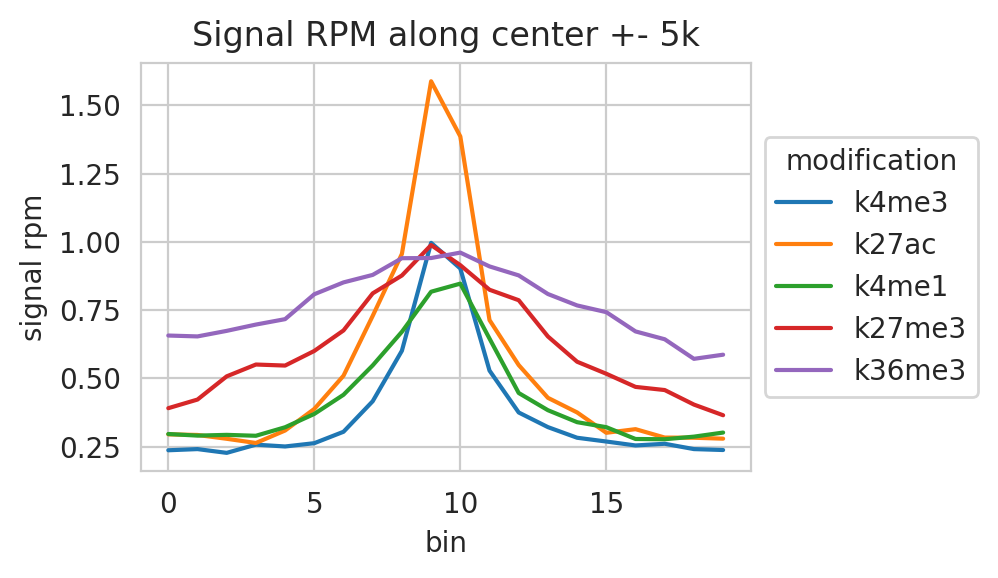

In [24]:
print('Signal RPM')
plt.figure(figsize=(5, 3))
ax = plt.axes()
# Show aggregated data, since we don't want error plots
t = all_bws_profiles_rpm[['modification'] + [f'rpm_pc_{i}' for i in range(20)]].groupby(['modification']).mean().reset_index()
t.rename({f'rpm_pc_{i}': i for i in range(20)}, axis=1, inplace=True)
t = pd.melt(t, id_vars=['modification'])
sns.lineplot(data=t, x="variable", y="value", hue="modification", err_style=None,
             hue_order=MODIFICATIONS, 
             ax=ax)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('bin')
ax.set_ylabel('signal rpm')
ax.set_title('Signal RPM along center +- 5k')
plt.tight_layout()
plt.show()

Signal RPM


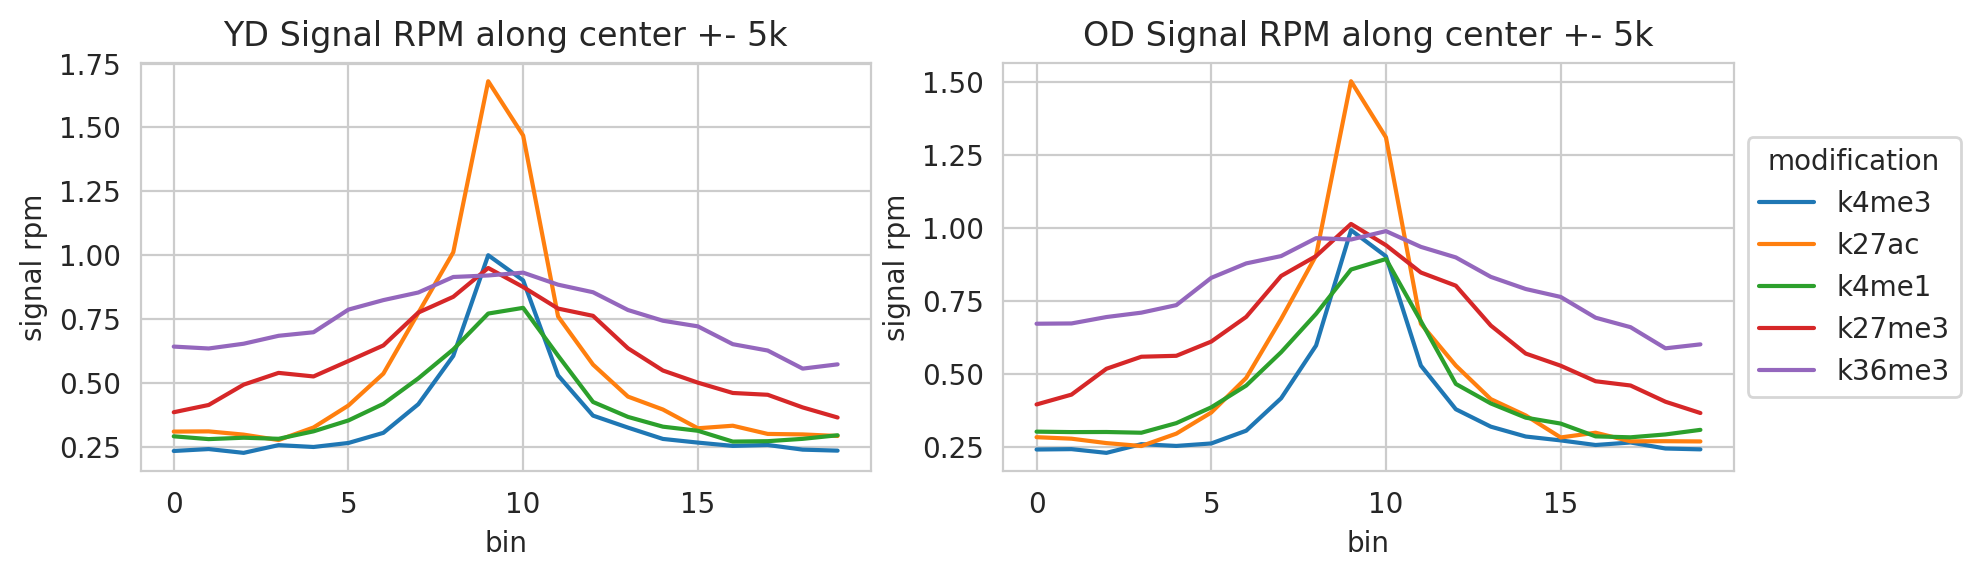

In [25]:
print('Signal RPM')
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, a in enumerate(AGES):
    ax = axs[i]
    # Show aggregated data, since we don't want error plots
    t = all_bws_profiles_rpm[all_bws_profiles_rpm['cell'] == a][
        ['modification'] + [f'rpm_pc_{i}' for i in range(20)]
    ].groupby(['modification']).mean().reset_index()
    t.rename({f'rpm_pc_{i}': i for i in range(20)}, axis=1, inplace=True)
    t = pd.melt(t, id_vars=['modification'])
    sns.lineplot(data=t, x="variable", y="value", hue="modification", err_style=None,
                 hue_order=MODIFICATIONS, ax=ax)

    ax.set_xlabel('bin')
    ax.set_ylabel('signal rpm')
    ax.set_title(f'{a} Signal RPM along center +- 5k')
    if i == len(axs) - 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
# ax.set_xticks([], minor=False)
# ax.set_xticklabels([])
plt.tight_layout()
plt.show()

In [26]:
# print('Control')
# plt.figure(figsize=(5, 3))
# ax = plt.axes()
# # Show aggregated data, since we don't want error plots
# t = all_bws_profiles_rpm[
#     ['modification'] + [f'ipc_{i}' for i in range(20)]
# ].groupby(['modification']).mean().reset_index()
# t.rename({f'ipc_{i}': i for i in range(20)}, axis=1, inplace=True)
# t = pd.melt(t, id_vars=['modification'])
# sns.lineplot(data=t, x="variable", y="value", hue="modification", err_style=None,
#              hue_order=MODIFICATIONS,
#              ax=ax)
# sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_xlabel('bin')
# ax.set_ylabel('control coverage')
# ax.set_title('Control along center +- 5k')
# plt.tight_layout()
# plt.show()

# Load full peaks coverage

In [27]:
coverages_path = f'{PATH}/coverages.tsv.gz'
# ! rm {coverages_path} || true
if os.path.exists(coverages_path):
    coverages_df = pd.read_csv(coverages_path, sep='\t', compression='gzip')
else:
    # coverages_df = load_signal_peaks_profile(all_bws, CONSENSUS_PEAKS, load_control=True, peaks=100_000, covtype=COV_TYPE)
    coverages_df = load_signal_peaks_profile(all_bws, CONSENSUS_PEAKS, load_control=False, peaks=100_000, covtype=COV_TYPE)
    coverages_df.to_csv(coverages_path, sep='\t', index=None, compression='gzip')
coverages_df.sample(3)

,modification,cell,replicate,peak,length,coverage
1271205,k4me1,OD,OD8,chr1:31971510-31972080,570,182.490125
3247363,k36me3,YD,YD20,chr12:62912700-62913100,400,80.073407
1855134,k27ac,YD,YD17,chr14:78019950-78034000,14050,2752.404801


Signal coverage


/tmp/ipykernel_3413737/2428410316.py:15: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=t, x='modification', y=value, hue='cell',


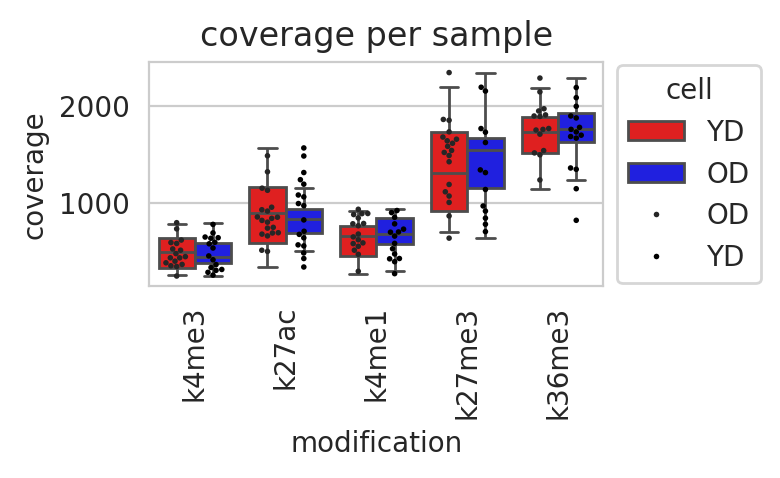

In [28]:
print('Signal coverage')
plot_split(coverages_df, 'coverage', 'coverage per sample', True)

In [ ]:
# del coverages_df_beta, b_sums, coverages_df_norm

In [51]:
t = coverages_df[['modification', 'cell', 'replicate', 'coverage']].copy()
t['npeaks'] = 1
peaks_coverages_df = t.groupby(['modification', 'cell', 'replicate']).sum().reset_index()
del t
peaks_coverages_df.rename({'coverage': 'peaks_coverage'}, axis=1, inplace=True)
peaks_coverages_df.sample(3)

,modification,cell,replicate,peaks_coverage,npeaks
144,k4me3,OD,OD3,1.375996e+07,17297
55,k27me3,OD,OD7,1.109528e+07,10367
139,k4me3,OD,OD17,4.242576e+06,17297


Summary coverage in peaks


/tmp/ipykernel_3413737/2428410316.py:15: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=t, x='modification', y=value, hue='cell',


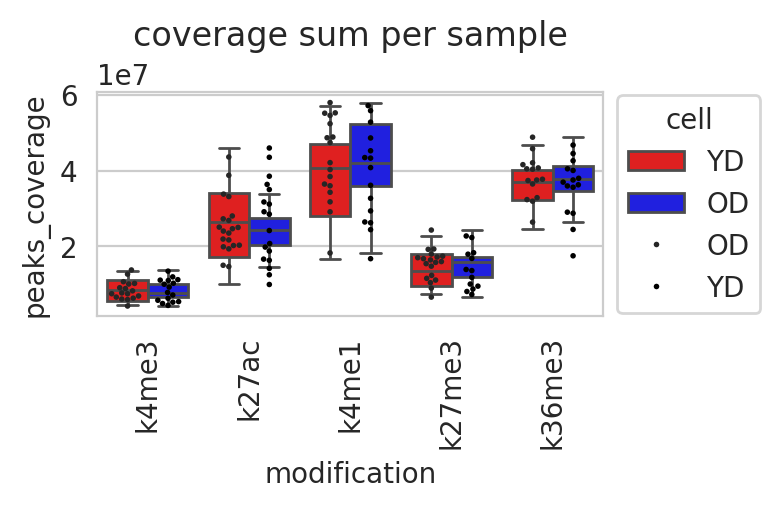

In [52]:
print('Summary coverage in peaks')
plot_split(peaks_coverages_df, 'peaks_coverage', 'coverage sum per sample', True)

Summary peaks


/tmp/ipykernel_3413737/2428410316.py:15: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=t, x='modification', y=value, hue='cell',
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, Us

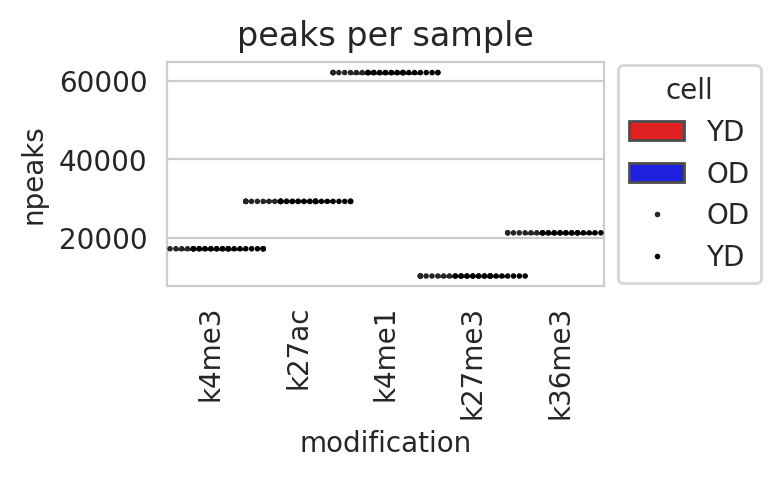

In [53]:
print('Summary peaks')
plot_split(peaks_coverages_df, 'npeaks', 'peaks per sample', True)

In [54]:
# SPAN produces CPM normalized coverage
print('Normalize by summary in peaks')
coverages_df_norm = coverages_df.merge(peaks_coverages_df, on=['modification', 'cell', 'replicate'])
coverages_df_norm['coverage_norm'] = coverages_df_norm['coverage'] / (coverages_df_norm['peaks_coverage'] / 1e6)
coverages_df_norm.sample(3)

Normalize by summary in peaks


,modification,cell,replicate,peak,length,coverage,peaks_coverage,npeaks,coverage_norm
630207,k4me1,YD,YD11,chr3:131219900-131224000,4100,861.624373,3.611210e+07,62050,23.859717
3612754,k27ac,YD,YD21,chr18:21173240-21176790,3550,397.152194,3.171119e+07,29334,12.524041
126488,k27ac,YD,YD20,chr1:206554330-206559000,4670,299.720752,1.662303e+07,29334,18.030451


# RPM

In [55]:
# print('Normalize by RPM')
# coverages_df_norm = coverages_df.merge(total_coverages_df, on=['modification', 'cell', 'replicate'])
# coverages_df_norm['coverage_norm'] = coverages_df_norm['coverage'] / (coverages_df_norm['total_coverage'] / 1e6)
# coverages_df_norm.sample(3)

In [56]:
# print('Average RPM per sample')
# plot_split(coverages_df_norm, 'coverage_norm', 'coverage_norm per sample', True)

# Beta

In [57]:
# def r0(o, c):
#     """ Correlation to estimate b """
#     assert o.size == c.size
#     return pearsonr(o, c)[0]
#
# def compute_betas(bw_df, chrom_sizes, start, end, bin, covtype, bwpath=BW_PATH, stepB = 0.01):
#     rows = []
#     for _, (bwfile, mod, cell, rep) in tqdm(list(bw_df[['file', 'modification', 'cell', 'replicate']].iterrows())):
#         bwcfile = 'input.bw'
#         print(mod, cell, rep, bwfile, bwcfile)
#         for chr, chr_size in chrom_sizes.items():
#             assert chr_size > end
#             print(f'Computing {mod} {cell} {rep} binned {bin}bp beta on chr {chr} {chr_size}')
#             try:
#                 with pyBigWig.open(os.path.join(bwpath, bwfile)) as bw:
#                     cov_signal = np.asarray(bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True, type=covtype))
#                     cov_signal = np.nan_to_num(cov_signal, copy=False, nan=0, posinf=0, neginf=0)
#                     cov_signal = np.array([0.0 if x is None else x for x in cov_signal])
#                     cov_signal_sum = cov_signal.sum()
#                     print(f'Signal: {cov_signal_sum}')
#                 with pyBigWig.open(os.path.join(bwpath, bwcfile)) as bwc:
#                     cov_control = np.asarray(bwc.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True, type=covtype))
#                     cov_control = np.nan_to_num(cov_control, copy=False, nan=0, posinf=0, neginf=0)
#                     cov_control = np.array([0.0 if x is None else x for x in cov_control])
#                     cov_control_sum = cov_control.sum()
#                     print(f'Control: {cov_control_sum}')
#                 print(f'Normalize control to signal scale: {cov_signal_sum / cov_control_sum}')
#                 print('Estimating b between 0 and 1')
#                 bs = np.linspace(0, 1, num = int(1 / stepB) + 1)
#                 bCs = [fabs(r0(cov_signal - b * cov_control * (cov_signal_sum / cov_control_sum), cov_control)) for b in bs]
#                 bI = np.argmin(bCs)
#                 b = bs[bI]
#                 print(f'I={bI}, b={b}, correlation={bCs[bI]}')
#                 rows.append((mod, cell, rep, chr, cov_signal_sum, cov_control_sum, b, bCs[bI]))
#             except RuntimeError as e:
#                 print(e)
#                 pass  # Ignore broken profiles
#             except Exception as e:
#                 print(e)
#                 pass  # Ignore broken profiles
#     return pd.DataFrame(
#         columns=['modification', 'cell', 'replicate', 'chr', 'coverage_sum', 'input_coverage_sum', 'b', 'correlation'],
#         data=rows
#     )

In [58]:
# betas_path = f'{PATH}/betas.tsv.gz'
# # ! rm {betas_path} || true
# if os.path.exists(betas_path):
#     df_betas = pd.read_csv(betas_path, sep='\t', compression='gzip')
# else:
#     # We see that there are consensus peaks in chr1:1_000_000-4_000_000 in genome browser
#     df_betas = compute_betas(all_bws, {'chr1': CHROM_SIZES['chr1']}, 1_000_000, 4_000_000, 100, covtype=COV_TYPE)
#     df_betas.to_csv(betas_path, sep='\t', index=None, compression='gzip')
# df_betas.sample(3)

In [59]:
# df_betas['b'].hist(figsize=(3, 2))
# plt.show()

In [60]:
# t = df_betas.groupby(['modification', 'cell', 'replicate']).mean().reset_index()
# coverages_df_beta = coverages_df.merge(t, on=['modification', 'cell', 'replicate'])
# coverages_df_beta.sample(3)

In [61]:
# coverages_df_beta = coverages_df.merge(df_betas, on=['modification', 'cell', 'replicate'])
# coverages_df_beta = coverages_df_beta[['modification', 'cell', 'replicate', 'peak',
#                                        'coverage', 'input_coverage', 'coverage_sum', 'input_coverage_sum', 'b']]
# coverages_df_beta['coverage_b'] = np.clip(
#     coverages_df_beta['coverage'] -  coverages_df_beta['b'] * coverages_df_beta['input_coverage'] *
#     (coverages_df_beta['coverage_sum'] / coverages_df_beta['input_coverage_sum']),
#     a_min=0.0, a_max=None
# )
# coverages_df_beta.sample(3)

In [62]:
# print('Average b-coverage')
# plot_split(coverages_df_beta, 'coverage_b', 'b_coverage per sample', True)

In [63]:
# print('Normalize by b-coverage summary in sample')
# b_sums = coverages_df_beta[['modification', 'cell', 'replicate', 'coverage_b']].groupby(['modification', 'cell', 'replicate']).sum().reset_index()
# b_sums.rename({'coverage_b': 'coverage_b_sum'}, axis=1, inplace=True)
# b_sums.sample(3)
# coverages_df_norm = coverages_df_beta.merge(b_sums, on=['modification', 'cell', 'replicate'])
# coverages_df_norm['coverage_norm'] = \
#     coverages_df_norm['coverage_b'] / (coverages_df_norm['coverage_b_sum'] / 1e6)
# coverages_df_norm.sample(3)

Average normalized coverage


/tmp/ipykernel_3413737/2428410316.py:15: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=t, x='modification', y=value, hue='cell',
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, Us

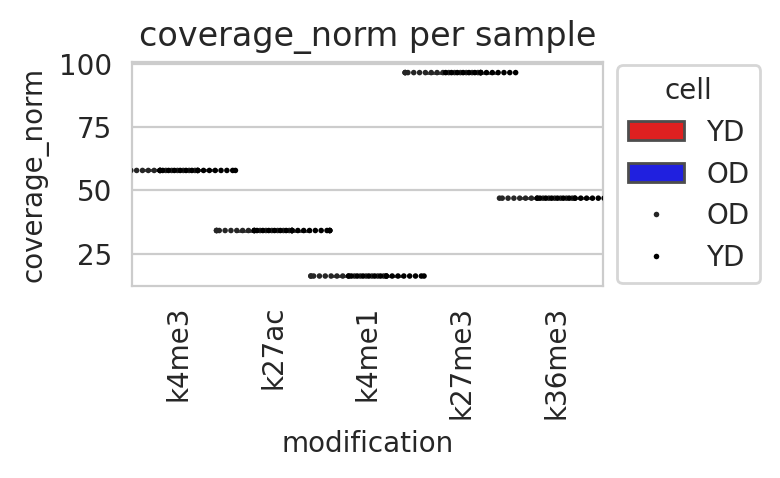

In [120]:
print('Average normalized coverage')
plot_split(coverages_df_norm, 'coverage_norm', 'coverage_norm per sample', True)

# RPK

In [65]:
# Normalize to length so that difference in short regions has better contrast
coverages_df_norm[['chr', 'start', 'end']] = coverages_df_norm['peak'].str.split(r'[:-]', expand=True)
coverages_df_norm['length'] = coverages_df_norm['end'].astype(int)-coverages_df_norm['start'].astype(int)
coverages_df_norm['coverage_norm_rpk'] = coverages_df_norm['coverage_norm'] / coverages_df_norm['length'] * 1e3

Average RPKM per sample


/tmp/ipykernel_3413737/2428410316.py:15: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=t, x='modification', y=value, hue='cell',
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, U

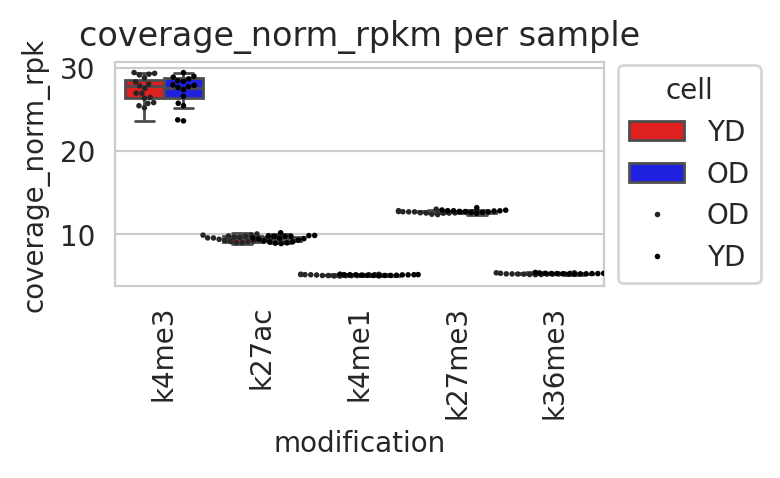

In [119]:
print('Average RPKM per sample')
plot_split(coverages_df_norm, 'coverage_norm_rpk', 'coverage_norm_rpkm per sample', True)

# Heatmap correlation

In [68]:
# print('Normalized')
# for m in MODIFICATIONS:
#     print(m)
#     t = coverages_df_norm[coverages_df_norm['modification'] == m][['modification', 'cell', 'replicate', 'peak', 'coverage_norm']]
#     t = pd.pivot(t, index=['modification', 'replicate', 'cell'], columns=['peak'], values=['coverage_norm']).reset_index()
#     t = t.set_axis(t.columns.map('_'.join), axis=1, copy=False)
#     # display(t)
#     t.drop(['modification_', 'cell_'], axis=1, inplace=True)
#     # display(t)
#     t.set_index('replicate_', inplace=True)
#     # Compute the correlation matrix
#     corr = t.corr()
#     # Generate a heatmap
#     sns.heatmap(corr, annot=True, cmap='coolwarm')
#     # display(t)
#     # sns.clustermap(t)
#     plt.show()


# PCA

In [69]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px

def show_pca(m, a, ages, replicates, n=10, pcx=1, pcy=2, plot_variances=False, ax=None):
    n_components = min([a.shape[0], a.shape[1], n])
    pca = PCA(n_components=n_components, random_state=42)
    t = StandardScaler().fit_transform(a) # (n_samples x n_features)
    result_pca = pca.fit_transform(t)
    # print('Explained variation', int(np.sum(pca.explained_variance_ratio_) * 100), '%')
    data = {'Donor': replicates, 'Age': ages}
    for i in range(n_components):
        data[f'pc{i + 1}'] = result_pca[:, i]
    td = pd.DataFrame(data)
    ax_was_none = ax is None
    if ax is None:
        plt.figure(figsize=(2.5, 2))
        ax = plt.axes()
    sns.scatterplot(td, x=f'pc{pcx}', y=f'pc{pcy}', hue='Age', palette={'YD': 'red', 'OD': 'blue'}, ax=ax)
    ax.set_xlabel(f'PC{pcx} {int(pca.explained_variance_ratio_[0] * 100)}%')
    ax.set_ylabel(f'PC{pcy} {int(pca.explained_variance_ratio_[1] * 100)}%')
    ax.set_xticks([], minor=False)
    ax.set_yticks([], minor=False)
    ax.set_title(f'{m}, d={a.shape[1]}')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if ax_was_none:
        plt.show()
    if plot_variances:
        plt.figure(figsize=(3, 1))
        g = sns.barplot(x=list(range(n_components)), y=pca.explained_variance_ratio_, color='gray')
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        plt.tight_layout()
        plt.show()
    return result_pca

Score=coverage, per1kbp=False


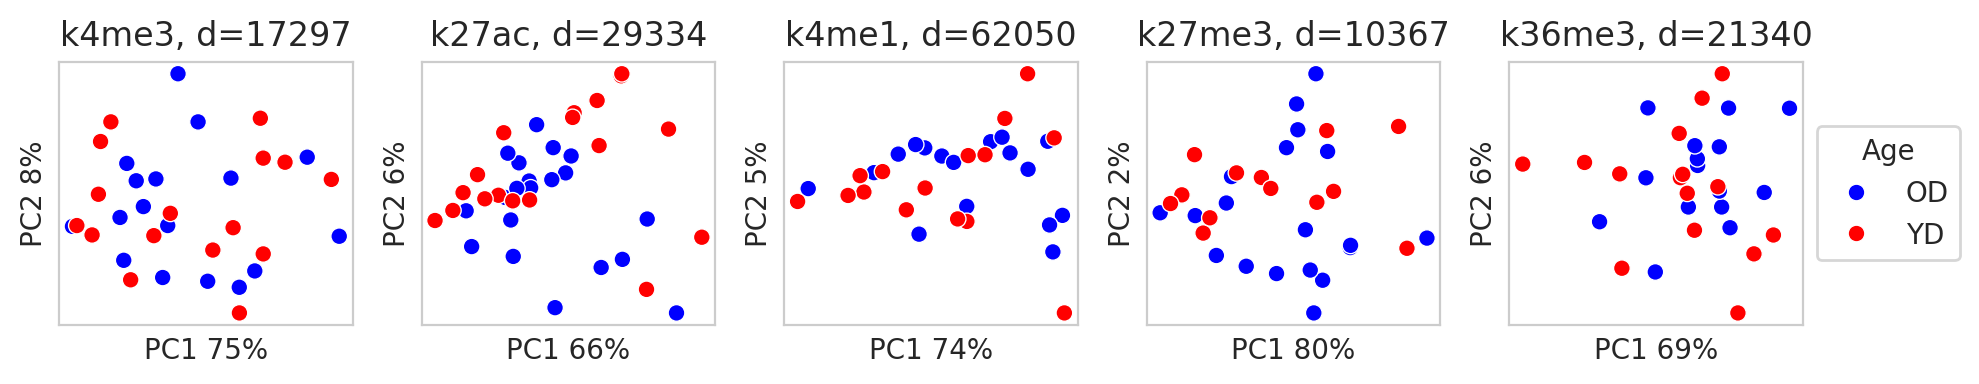

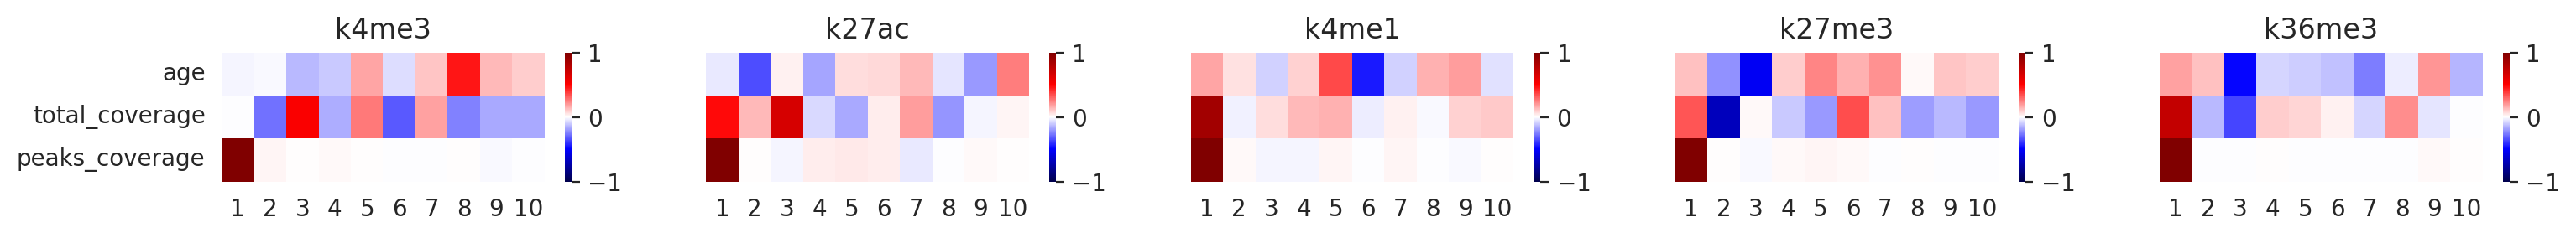

Score=coverage, per1kbp=True


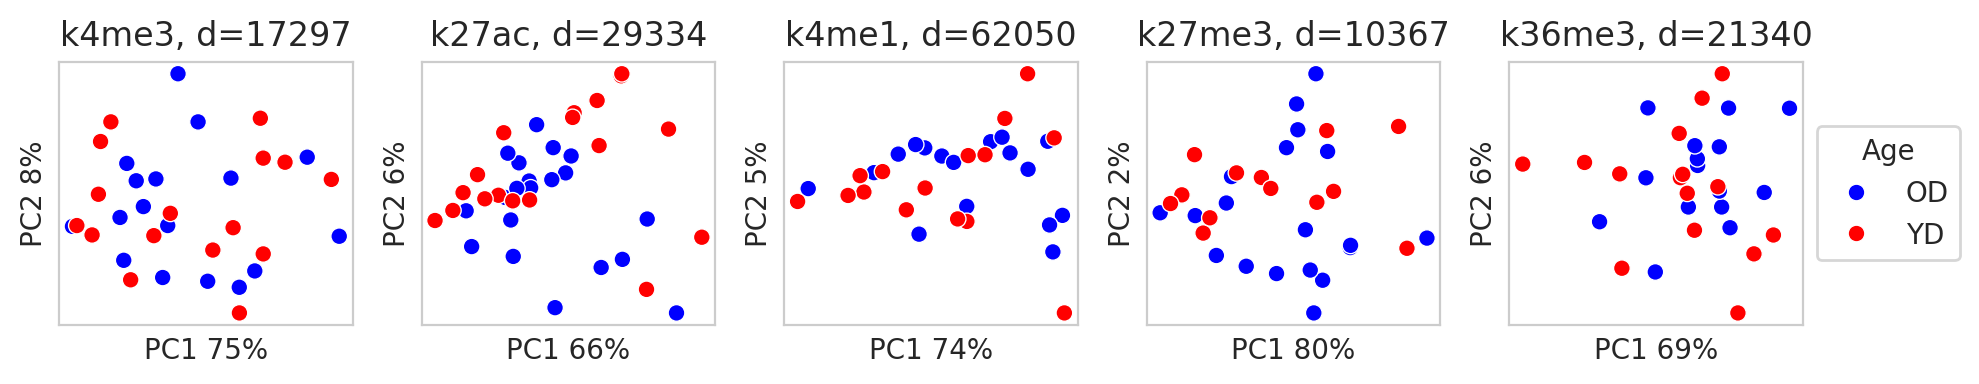

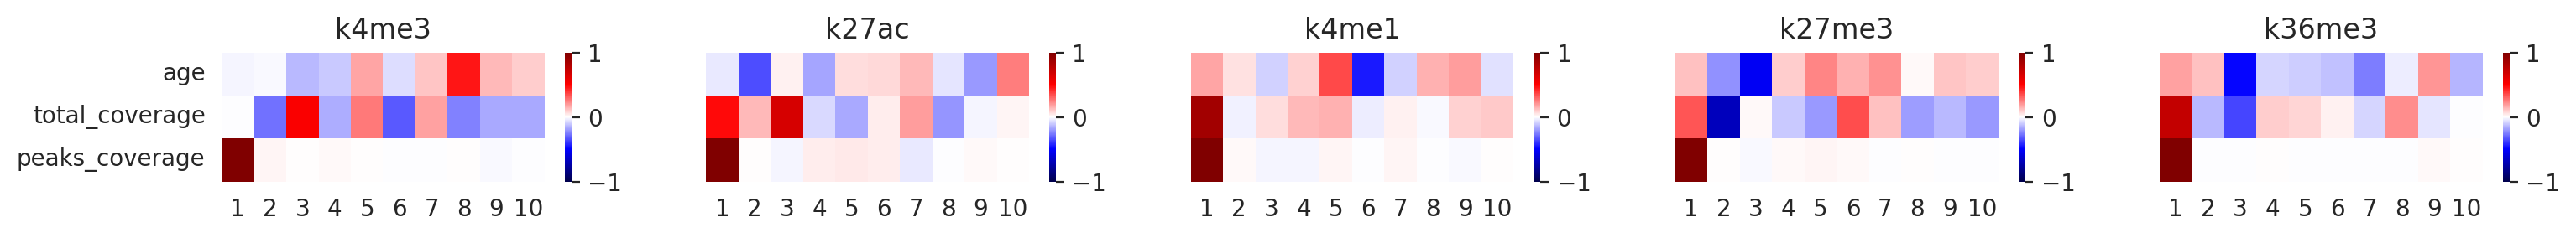

Score=coverage_norm, per1kbp=False


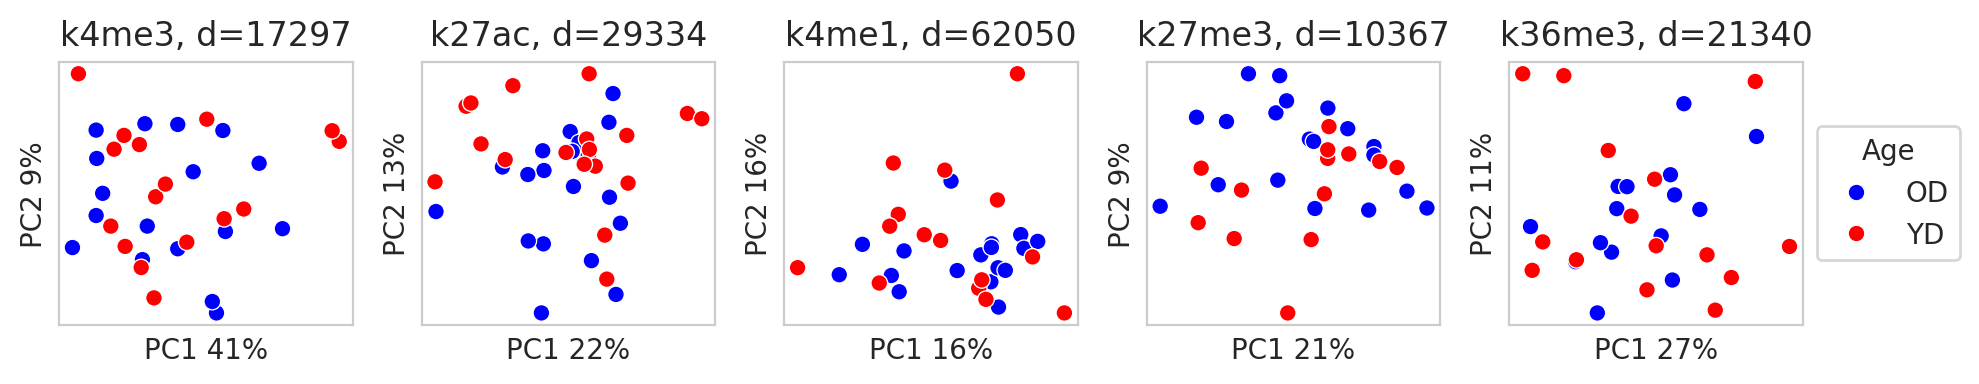

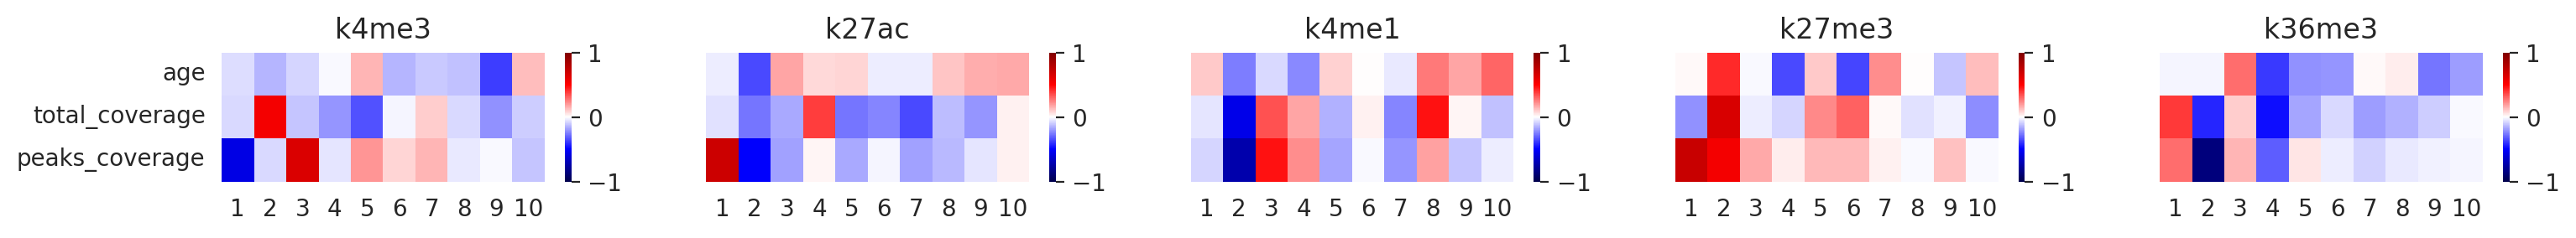

Score=coverage_norm, per1kbp=True


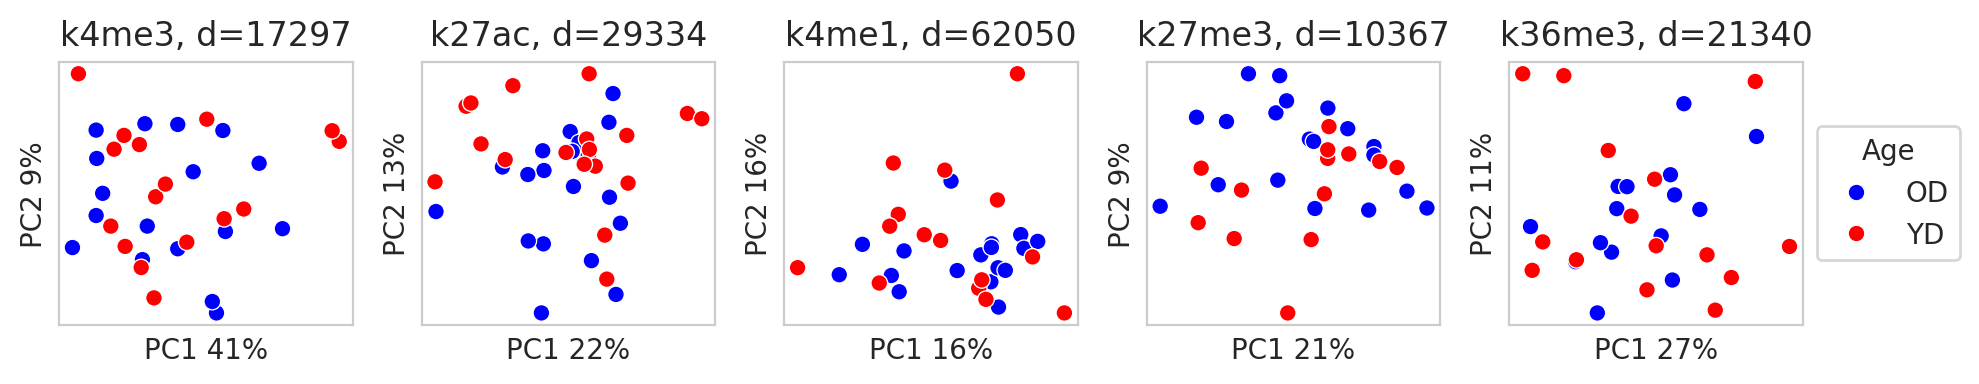

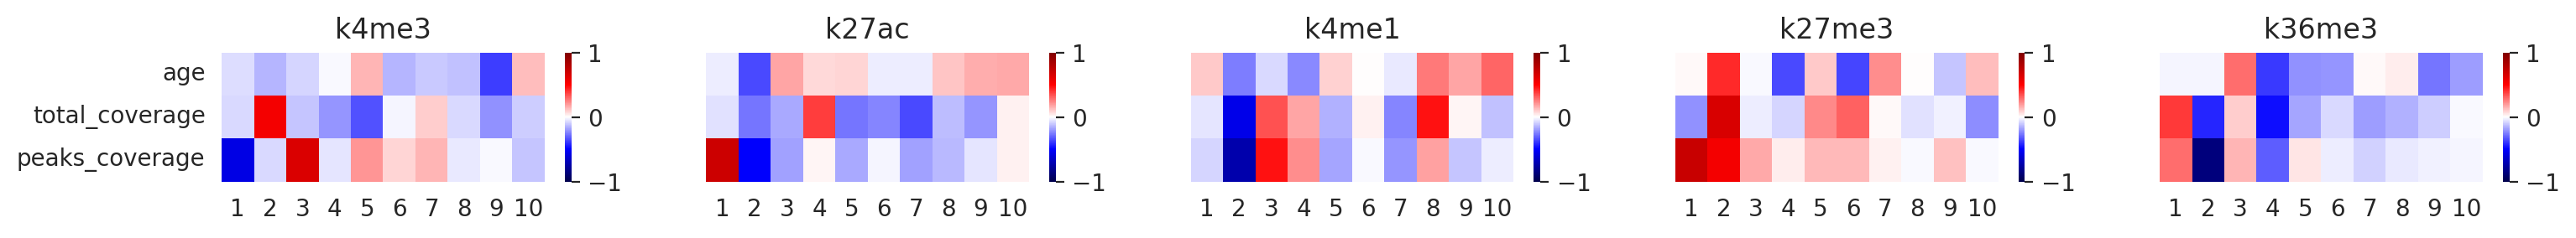

In [70]:
for (df, score), rpk in product([(coverages_df, 'coverage'),
                                 # (coverages_df_beta, 'coverage_b'),
                                 (coverages_df_norm, 'coverage_norm')], [False, True]):
    ts = {}
    if COV_TYPE == 'mean' and rpk == True:
        continue
    print(f'Score={score}, per1kbp={rpk}')
    plt.figure(figsize=(10, 3.5))
    axs = [plt.subplot(2, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        # print(m)
        ax = axs[i]
        t = df[df['modification'] == m].copy()
        if rpk:
            # Normalize to length so that difference in short regions has better contrast
            t[['chr', 'start', 'end']] = t['peak'].str.split(r'[:-]', expand=True)
            t[score] = t[score] / (t['end'].astype(int)-t['start'].astype(int)) * 1e3
        t = t[['modification', 'cell', 'replicate', 'peak', score]]
        t = pd.pivot(t, index=['modification', 'replicate', 'cell'], columns=['peak'], values=[score]).reset_index()
        t = t.set_axis(t.columns.map('_'.join), axis=1, copy=False)
        t.rename({'modification_': 'modification', 'cell_': 'cell', 'replicate_': 'replicate'}, axis=1, inplace=True)
        result_pca = show_pca(m, t[t.columns[3:]].values, t['cell'], t['replicate'], ax=ax)
        n_components = result_pca.shape[1]
        t = t.merge(total_coverages_df, on=['modification', 'cell', 'replicate'])
        t = t.merge(peaks_coverages_df, on=['modification', 'cell', 'replicate'])
        t['age'] = [1 if a[0] == 'O' else -1 for a in t['cell']]
        cors = {v: [pearsonr(t[v], result_pca[:, c])[0] for c in range(n_components)] for v in ['age', 'total_coverage', 'peaks_coverage']}
        # display(cors)
        ts[m] = pd.DataFrame(cors, index=[c + 1 for c in range(n_components)])
        if i == len(axs) - 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(18, 1))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.heatmap(ts[m].T, cmap=plt.cm.seismic, vmin=-1, vmax=1, ax=ax)
        ax.set_title(m)
        if i > 0:
            ax.set_yticklabels([])
    plt.show()



# Differential peak calling

In [71]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

def diff_peak_calling(df, score, multiple_method='fdr_bh'):
    ts = []
    for m, dfm in tqdm(df[['modification', 'cell', 'replicate', 'peak', 'coverage_norm']].groupby('modification')):
        rows = []
        print(m)
        for peak, dft in dfm.groupby('peak'):
            yds_vals = dft[dft['cell'] == 'YD'][score]
            ods_vals = dft[dft['cell'] == 'OD'][score]
            p_t = ttest_ind(yds_vals, ods_vals)[1] or 1.0
            p_mwu = mannwhitneyu(yds_vals, ods_vals).pvalue or 1.0
            yds_mean = yds_vals.mean()
            ods_mean = ods_vals.mean()
            lfc = np.log2((ods_mean + 1e-10) / (yds_mean + 1e-10))
            rows.append((m, peak, yds_mean, ods_mean, p_t, p_mwu, lfc))
        t = pd.DataFrame(columns=['modification', 'peak', 'yds_mean', 'ods_mean', 'p_t', 'p_mwu', 'od_yd_log2_fc'],
                         data=rows)
        t['p_t'].fillna(1.0, inplace=True)
        t['p_mwu'].fillna(1.0, inplace=True)
        t['p_t_adj'] = multipletests(t['p_t'], method=multiple_method)[1]
        t['p_mwu_adj'] = multipletests(t['p_mwu'], method=multiple_method)[1]
        ts.append(t)
    stats_df = pd.concat(ts).reset_index(drop=True)
    stats_df['mp_t'] = -np.log10(stats_df['p_t'])
    stats_df['mp_t_adj'] = -np.log10(stats_df['p_t_adj'])
    stats_df['mp_mwu'] = -np.log10(stats_df['p_mwu'])
    stats_df['mp_mwu_adj'] = -np.log10(stats_df['p_mwu_adj'])
    return stats_df

In [72]:
stats_df = diff_peak_calling(coverages_df_norm, 'coverage_norm')
stats_df.sort_values(by='p_t').head(10)

  0%|          | 0/5 [00:00<?, ?it/s]

k27ac
k27me3
k36me3
k4me1
k4me3


,modification,peak,yds_mean,ods_mean,p_t,p_mwu,od_yd_log2_fc,p_t_adj,p_mwu_adj,mp_t,mp_t_adj,mp_mwu,mp_mwu_adj
66150,k4me1,chr11:64453900-64456800,16.436191,20.338676,0.000004,0.000033,0.307350,0.265348,0.984471,5.368926,0.576184,4.485647,0.006797
81206,k4me1,chr18:22054400-22056370,6.568429,5.103679,0.000030,0.000249,-0.364011,0.930822,0.984471,4.518866,0.031133,3.603292,0.006797
137463,k4me3,chr6:43061520-43061700,2.513581,4.810822,0.000037,0.000125,0.936539,0.451140,1.000000,4.435004,0.345688,3.903490,-0.000000
22579,k27ac,chr5:179945470-179946520,7.359553,9.208899,0.000041,0.000382,0.323411,0.719411,0.771045,4.386776,0.143023,3.417719,0.112920
58791,k36me3,chr7:66804600-66805200,4.105469,2.986931,0.000041,0.000308,-0.458883,0.880235,1.000000,4.384596,0.055401,3.511642,-0.000000
131176,k4me3,chr1:207996220-207997040,12.170044,19.924743,0.000052,0.000167,0.711227,0.451140,1.000000,4.282629,0.345688,3.777223,-0.000000
17244,k27ac,chr2:185630000-185632130,7.251784,10.536996,0.000058,0.000084,0.539056,0.719411,0.771045,4.239926,0.143023,4.074730,0.112920
29999,k27me3,chr11:124790280-124793100,37.196807,31.524725,0.000072,0.000170,-0.238695,0.249024,0.485699,4.144482,0.603759,3.770124,0.313633
10898,k27ac,chr19:38397500-38398290,5.291426,3.755771,0.000075,0.000306,-0.494547,0.719411,0.771045,4.127558,0.143023,3.514929,0.112920
107896,k4me1,chr5:172064020-172065000,2.249389,4.049909,0.000089,0.000289,0.848357,0.930822,0.984471,4.052296,0.031133,3.539536,0.006797


In [73]:
def save_diff(stats_df, name, score, significance_thr, abs_log2_fc_thr, bed3=False):
    t = stats_df[(stats_df['modification']==m) &
                 (stats_df[score] <= significance_thr) &
                 (np.fabs(stats_df['od_yd_log2_fc']) >= abs_log2_fc_thr)].copy()
    print(f'Peaks {name} with significance < {significance_thr} and abs log2 fc > {abs_log2_fc_thr}: {len(t)}')
    if len(t) == 0:
        return
    t[['chr', 'start', 'end']] = t['peak'].str.split(r'[:-]', expand=True)
    t['name'] = t.index.astype(str) + ' ' + name
    t = t[['chr', 'start', 'end', 'name', score, 'od_yd_log2_fc']].copy()
    t.sort_values(by=['chr', 'start', 'end'], inplace=True)
    if bed3:
        t[['chr', 'start', 'end']].to_csv(f'{PATH}/{name}.bed', sep='\t', index=None, header=False)
    else:
        t.to_csv(f'{PATH}/{name}.bed', sep='\t', index=None, header=False)


In [74]:
for m in MODIFICATIONS:
    print(m, sum(stats_df['modification']==m))
    save_diff(stats_df, f'{m}_diff_p0.05', 'p_t', significance_thr=0.05, abs_log2_fc_thr=0)
    save_diff(stats_df, f'{m}_diff_p0.05_abslfc_0.1', 'p_t', significance_thr=0.05, abs_log2_fc_thr=0.1)
    save_diff(stats_df, f'{m}_diff_p0.05_abslfc_0.25', 'p_t', significance_thr=0.05, abs_log2_fc_thr=0.25)

k4me3 17297
Peaks k4me3_diff_p0.05 with significance < 0.05 and abs log2 fc > 0: 270
Peaks k4me3_diff_p0.05_abslfc_0.1 with significance < 0.05 and abs log2 fc > 0.1: 263
Peaks k4me3_diff_p0.05_abslfc_0.25 with significance < 0.05 and abs log2 fc > 0.25: 104
k27ac 29334
Peaks k27ac_diff_p0.05 with significance < 0.05 and abs log2 fc > 0: 1964
Peaks k27ac_diff_p0.05_abslfc_0.1 with significance < 0.05 and abs log2 fc > 0.1: 1938
Peaks k27ac_diff_p0.05_abslfc_0.25 with significance < 0.05 and abs log2 fc > 0.25: 915
k4me1 62050
Peaks k4me1_diff_p0.05 with significance < 0.05 and abs log2 fc > 0: 2645
Peaks k4me1_diff_p0.05_abslfc_0.1 with significance < 0.05 and abs log2 fc > 0.1: 2433
Peaks k4me1_diff_p0.05_abslfc_0.25 with significance < 0.05 and abs log2 fc > 0.25: 682
k27me3 10367
Peaks k27me3_diff_p0.05 with significance < 0.05 and abs log2 fc > 0: 860
Peaks k27me3_diff_p0.05_abslfc_0.1 with significance < 0.05 and abs log2 fc > 0.1: 679
Peaks k27me3_diff_p0.05_abslfc_0.25 with sign

# PCA on differential peaks

Score=coverage, per1kbp=False


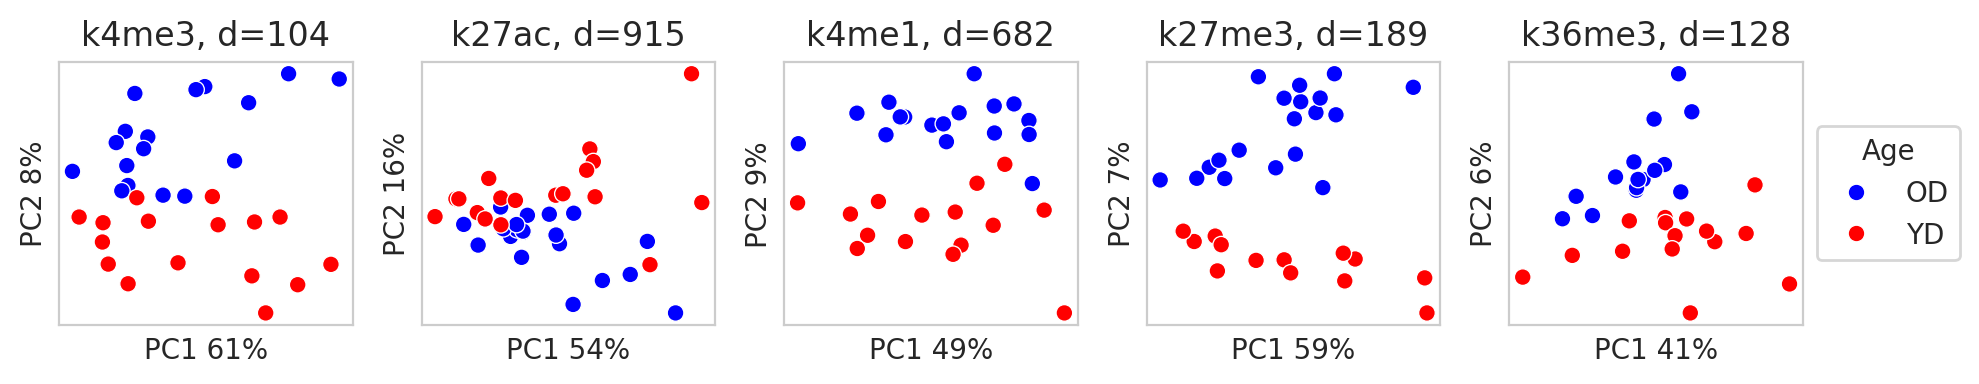

Score=coverage, per1kbp=True


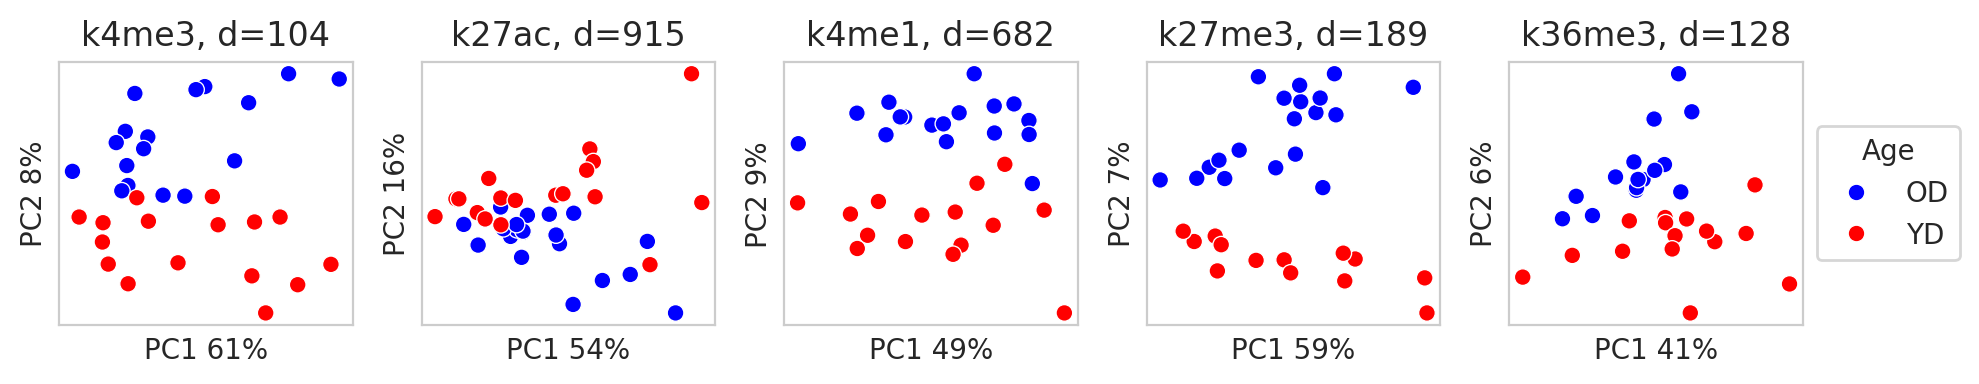

Score=coverage_norm, per1kbp=False


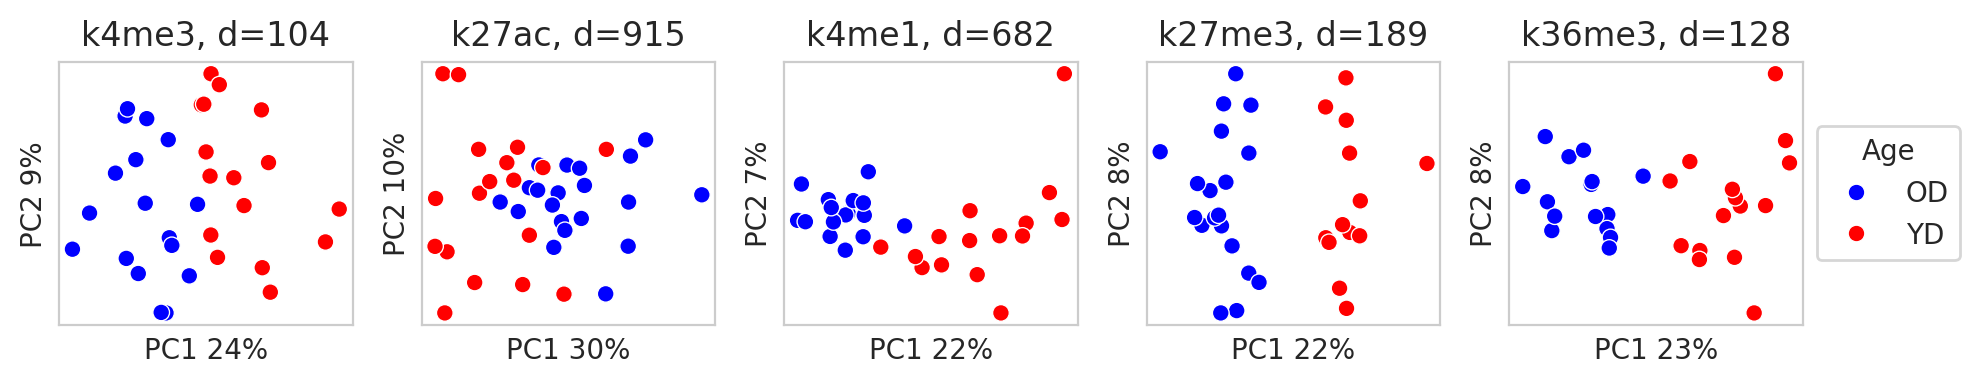

Score=coverage_norm, per1kbp=True


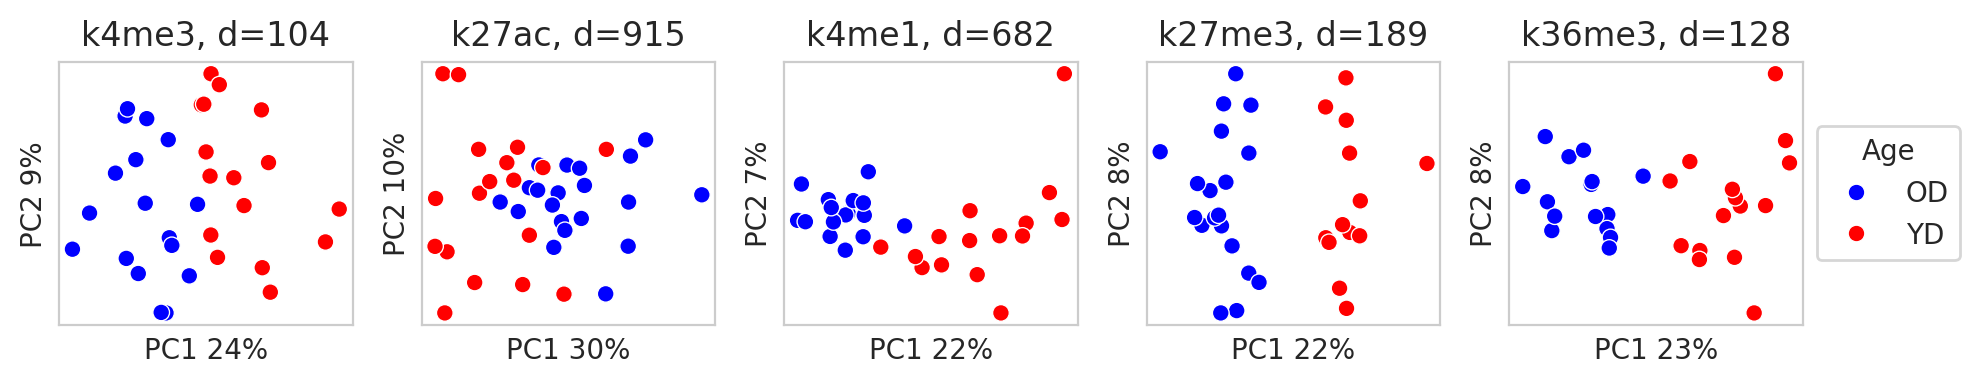

In [75]:
for (df, score), rpk in product([(coverages_df, 'coverage'),
                                 #(coverages_df_beta, 'coverage_b'),
                                 (coverages_df_norm, 'coverage_norm')], [False, True]):
    if COV_TYPE == 'mean' and rpk == True:
        continue
    print(f'Score={score}, per1kbp={rpk}')
    plt.figure(figsize=(10, 3.5))
    axs = [plt.subplot(2, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        # print(m)
        ax = axs[i]
        t = stats_df[(stats_df['modification']==m)
                     & (stats_df['p_t'] <= 0.05)
                     & (np.fabs(stats_df['od_yd_log2_fc']) >= 0.25)
        ].copy()
        if len(t) == 0:
            continue
        diff_peaks = set(t['peak'])
        t = df[
            (df['modification'] == m) &
            (df['peak'].isin(diff_peaks))
            ].copy()
        if rpk:
            # Normalize to length so that difference in short regions has better contrast
            t[['chr', 'start', 'end']] = t['peak'].str.split(r'[:-]', expand=True)
            t[score] = t[score] / (t['end'].astype(int)-t['start'].astype(int)) * 1e3
        t = t[['modification', 'cell', 'replicate', 'peak', score]]
        t = pd.pivot(t, index=['modification', 'replicate', 'cell'], columns=['peak'], values=[score]).reset_index()
        show_pca(m, t[t.columns[3:]].values, t['cell'], t['replicate'], 10, ax=ax)
        if i == len(axs) - 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
    plt.tight_layout()
    plt.show()

# DeSeq2 diff

In [ ]:
# ! mamba install -y -c bioconda -c conda-forge pydeseq2

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [ ]:
# deseq2_diffs = {}
# deseq2_df_norms = {}
#
# for m in tqdm(MODIFICATIONS):
#     print(m)
#     counts = coverages_df[coverages_df['modification']==m]
#     counts = counts[['cell', 'replicate', 'peak', 'coverage']].pivot(
#         index=['replicate', 'cell'], columns='peak', values='coverage').reset_index()
#
#     counts.set_index('replicate', inplace=True)
#     metadata = counts[['cell']].copy()
#     counts.drop('cell', axis=1, inplace=True)
#     counts.fillna(0, inplace=True)
#     counts = counts.astype(int)
#
#     dds = DeseqDataSet(counts=counts, metadata=metadata, design_factors='cell')
#     dds.deseq2()
#     stat_res = DeseqStats(dds, contrast=('cell', 'OD', 'YD'))
#     stat_res.summary()
#     deseq2_diffs[m] = stat_res.results_df
#     deseq2_df_norms[m] = pd.DataFrame(dds.layers["normed_counts"], index=metadata.index, columns=counts.columns)


In [ ]:
# for m in MODIFICATIONS:
#     res = deseq2_diffs[m]
#     print(m, 'diff p<0.05', len(res[res['pvalue']< 0.05]))
#     print(m, 'diff p_adj<0.05', len(res[res['padj']< 0.05]))
#     print(m, 'min abs log2fc', np.fabs(res[res['pvalue']< 0.05]['log2FoldChange']).min())
#     display(res.sort_values(by=['pvalue']).head(5))

In [ ]:
# res = deseq2_diffs['k27ac']
# res['mp_t'] = -np.log10(res['pvalue'])
# res['od_yd_log2_fc'] = res['log2FoldChange']
# res['peak'] = res.index
# fig = render_interactive_volcano(res, 'H3K27ac DeSeq2', 'mp_t', custom_data=False, x_thr=2)
# fig.show()

# Volcanos

In [ ]:
import plotly.graph_objects as go

def render_interactive_volcano(df, title, score,
                               significance_thr=-np.log10(0.05), abs_log2_fc_thr=0.25, x_thr=1,
                               custom_data=True, colors=None):
    # Adjust marker:
    marker = dict(size=6) # size
    if colors is not None:
        marker['color'] = colors
    if custom_data:
        fig = go.Figure(data=go.Scatter(
            x=df['od_yd_log2_fc'],
            y=df[score],
            mode='markers',
            text=df['peak'],
            hovertemplate=
            '<b>%{text}</b><br><br>' +
            'od_yd_log2fc: %{customdata[0]}<br>' +
            'YD_mean: %{customdata[1]}<br>' +
            'OD_mean: %{customdata[2]}<br>' +
            'T pval: %{customdata[3]}<br>' +
            'T pval adj: %{customdata[4]}<br>' +
            'MWU pval: %{customdata[5]}<br>' +
            'MWU pval adj: %{customdata[6]}<br>' +
            '<extra></extra>',
            customdata=df[['od_yd_log2_fc', 'yds_mean', 'ods_mean', 'p_t', 'p_t_adj', 'p_mwu', 'p_mwu_adj']].values,
            marker=marker,
            showlegend=False
        ))
    else:
        fig = go.Figure(data=go.Scatter(
            x=df['od_yd_log2_fc'],
            y=df[score],
            mode='markers',
            text=df['peak'],
            marker=marker,
            showlegend=False
        ))
    
    down = sum((df[score] > significance_thr) & (df['od_yd_log2_fc'] < abs_log2_fc_thr))
    up = sum((df[score] > significance_thr) & (df['od_yd_log2_fc'] > abs_log2_fc_thr))
    

    # Set x-axis limits
    fig.update_xaxes(range=[-x_thr, x_thr])

    # Add vertical line
    fig.add_shape(type="line",
                  x0=abs_log2_fc_thr,
                  y0=0,
                  x1=abs_log2_fc_thr,
                  y1=max(df[score]),
                  line=dict(color="Red",width=1, dash='dot')
                  )
    fig.add_shape(type="line",
                  x0=-abs_log2_fc_thr,
                  y0=0,
                  x1=-abs_log2_fc_thr,
                  y1=max(df[score]),
                  line=dict(color="Red",width=1, dash='dot')
                  )

    # Add horizontal line
    fig.add_shape(type="line",
                  x0=df['od_yd_log2_fc'].min(), y0=significance_thr, x1=df['od_yd_log2_fc'].max(), y1=significance_thr,
                  line=dict(color="Red",width=1, dash='dot')
                  )
    fig.add_trace(go.Scatter(
        x=[-x_thr * 0.9, x_thr * 0.9],
        y=[max(df[score]), max(df[score])],
        mode="text",
        text=[str(down), str(up)],
        textposition="bottom center",
        showlegend=False
    ))

    fig.update_layout(
        title=title,
        xaxis_title=f"Average log2fc od vs yd",
        yaxis_title="-log10 pvalue",
        # Theme
        plot_bgcolor = 'rgba(0, 0, 0, 0)',  # this sets the background color to be transparent
        paper_bgcolor = 'rgba(0, 0, 0, 0)',
        xaxis={
            'linecolor': 'lightgray',  # set the color of the x-axis line to black
            'linewidth': 1,
            'gridcolor': 'lightgray',  # set the grid line color to black
            'mirror': True
        },
        yaxis={
            'linecolor': 'lightgray',  # set the color of the y-axis line to black
            'linewidth': 1,
            'gridcolor': 'lightgray',  # set the grid line color to black
            'mirror': True
        },
        # Set width and height
        autosize=False,
        width=600,
        height=400
    )

    return fig

In [ ]:
def plot_top_diff(coverages_df_norm, m, peaks):
    plt.figure(figsize=(15, 6))
    axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
    for i, p in enumerate(peaks):
        ax = axs[i]
        tt = coverages_df_norm[(coverages_df_norm['modification'] == m) & (coverages_df_norm['peak'] == p)]
        sns.boxplot(data=tt, x='cell', y='coverage',
                    order=['YD', 'OD'],
                    palette={'YD': 'red', 'OD': 'blue'},
                    ax=ax)
        ax.set_title(f'{p}')
    for i, p in enumerate(peaks):
        ax = axs[i + 5]
        tt = coverages_df_norm[(coverages_df_norm['modification'] == m) & (coverages_df_norm['peak'] == p)]
        sns.boxplot(data=tt, x='cell', y='coverage_norm',
                    order=['YD', 'OD'],
                    palette={'YD': 'red', 'OD': 'blue'},
                    ax=ax)
        ax.set_title(f'{p}')
    plt.tight_layout()
    plt.show()

In [ ]:
stats_df['od_yd_log2_fc_color'] = 'lightgrey'
stats_df.loc[(stats_df['p_t']<0.05) & (stats_df['od_yd_log2_fc']>0.25), 'od_yd_log2_fc_color'] = 'blue'
stats_df.loc[(stats_df['p_t']<0.05) & (stats_df['od_yd_log2_fc']<-0.25), 'od_yd_log2_fc_color'] = 'red'

## H3K4me3

In [ ]:
import plotly.io as pio
import plotly.offline as pyo

# t = stats_df[stats_df['modification'] == 'k4me3']
# fig = render_interactive_volcano(t, f'H3K4me3 t-test n={len(t)}', 'mp_t', colors=t['od_yd_log2_fc_color'])
# fig.show() # render='png', render='notebook
#pyo.iplot(fig) # for Jupyter WRB
#pio.write_image(fig, 'figure.png')

In [ ]:
t = stats_df[(stats_df['modification']=='k4me3') & (np.fabs(stats_df['od_yd_log2_fc'])>=0.25)].sort_values(by=['mp_t'], ascending=False).head(5)
display(t)
plot_top_diff(coverages_df_norm, 'k4me3', t['peak'])

## H3K27ac

In [ ]:
# t = stats_df[stats_df['modification'] == 'k27ac']
# fig = render_interactive_volcano(t, f'H3K27ac t-test n={len(t)}', 'mp_t', colors=t['od_yd_log2_fc_color'])
# fig.show()

In [ ]:
t = stats_df[(stats_df['modification']=='k27ac') & (np.fabs(stats_df['od_yd_log2_fc'])>=0.25)].sort_values(by=['mp_t'], ascending=False).head(5)
display(t)
plot_top_diff(coverages_df_norm, 'k27ac', t['peak'])

## H3K4me1

In [ ]:
# t = stats_df[stats_df['modification'] == 'k4me1']
# fig = render_interactive_volcano(t, f'H3K4me1 t-test n={len(t)}', 'mp_t', colors=t['od_yd_log2_fc_color'])
# fig.show()

In [ ]:
t = stats_df[(stats_df['modification']=='k4me1') & (np.fabs(stats_df['od_yd_log2_fc'])>=0.25)].sort_values(by=['mp_t'], ascending=False).head(5)
display(t)
plot_top_diff(coverages_df_norm, 'k4me1', t['peak'])

## H3K27me3

In [ ]:
# t = stats_df[stats_df['modification'] == 'k27me3']
# fig = render_interactive_volcano(t, f'H3K27me3 t-test n={len(t)}', 'mp_t', colors=t['od_yd_log2_fc_color'])
# fig.show()

In [ ]:
t = stats_df[(stats_df['modification']=='k27me3') & (np.fabs(stats_df['od_yd_log2_fc'])>=0.25)].sort_values(by=['mp_t'], ascending=False).head(5)
display(t)
plot_top_diff(coverages_df_norm, 'k27me3', t['peak'])

## H3K36me3

In [ ]:
# t = stats_df[stats_df['modification'] == 'k36me3']
# fig = render_interactive_volcano(t, f'H3K36me3 t-test n={len(t)}', 'mp_t', colors=t['od_yd_log2_fc_color'])
# fig.show()

In [ ]:
t = stats_df[(stats_df['modification']=='k36me3') & (np.fabs(stats_df['od_yd_log2_fc'])>=0.25)].sort_values(by=['mp_t'], ascending=False).head(5)
display(t)
plot_top_diff(coverages_df_norm, 'k36me3', t['peak'])

# GSEA Diff ChIP-seq

Don't forget to annotate diff peaks with closest peaks

In [ ]:
from gseapy.plot import gseaplot
import gseapy as gp

gp.get_library_name()

In [ ]:
DIFF_PEAKS_WITH_GENES = {
    m: f'{PATH}/{m}_diff_p0.05_abslfc_0.1_genes.bed' for m in MODIFICATIONS
    # m: f'{PATH}/{m}_diff_p0.05_genes.bed' for m in MODIFICATIONS
}
for m in MODIFICATIONS:
    ! wc -l {DIFF_PEAKS_WITH_GENES[m]}
    pass

In [ ]:
m = 'k27me3'

diff_with_genes = pd.read_csv(
    DIFF_PEAKS_WITH_GENES[m], sep='\t',
    names=['chr', 'start', 'end', 'name', 'p_t', 'od_yd_log2_fc',
           'gene_chr', 'gene_start', 'gene_end', 'gene_name', 'distance'])

ranking = diff_with_genes[['gene_name', 'od_yd_log2_fc']].copy()
ranking.rename({'gene_name': 'Gene', 'od_yd_log2_fc': 'Rank'}, axis=1, inplace=True)
ranking.sort_values(by=['Rank'], inplace=True)
ranking.drop_duplicates('Gene', inplace=True)

pre_res = gp.prerank(
    rnk=ranking,
    gene_sets = ['KEGG_2021_Human', 'ENCODE_TF_ChIP-seq_2015', 'GWAS_Catalog_2023', 'Reactome_2022',
                 'GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023',
                 'GTEx_Aging_Signatures_2021', 'GTEx_Tissue_Expression_Down', 'GTEx_Tissue_Expression_Up'],
    seed = 42, min_size=10)
rows = []
for term in pre_res.results.keys():
    rows.append((term, pre_res.results[term]['fdr'], pre_res.results[term]['es'], pre_res.results[term]['nes']))
res_df = pd.DataFrame(rows, columns=['term', 'fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop=True)
del rows
res_df

In [ ]:
pre_res.plot(terms='GTEx_Tissue_Expression_Up__GTEX-WYJK-1626-SM-3NM9J thyroid male 50-59 years')
plt.show()

# Load signal on diff union

In [76]:
import tempfile
tf = tempfile.mktemp()
tf2 = tempfile.mktemp()
! touch {tf}
for m in MODIFICATIONS:
    ! wc -l {PATH}/{m}_diff_p0.05_abslfc_0.25.bed
    ! cat {PATH}/{m}_diff_p0.05_abslfc_0.25.bed >> {tf}
    pass
! cat {tf} | sort -k1,1 -k2,2n -k3,3n > {tf2}
! bedtools merge -i {tf2} > {PATH}/all_diff.bed
! wc -l {PATH}/all_diff.bed
! rm {tf} {tf2}

UNION_DIFF_PEAKS = {m: f'{PATH}/all_diff.bed' for m in MODIFICATIONS}

104 /home/jetbrains/data/2018_chipseq_y20o20/k4me3_diff_p0.05_abslfc_0.25.bed
915 /home/jetbrains/data/2018_chipseq_y20o20/k27ac_diff_p0.05_abslfc_0.25.bed
682 /home/jetbrains/data/2018_chipseq_y20o20/k4me1_diff_p0.05_abslfc_0.25.bed
189 /home/jetbrains/data/2018_chipseq_y20o20/k27me3_diff_p0.05_abslfc_0.25.bed
128 /home/jetbrains/data/2018_chipseq_y20o20/k36me3_diff_p0.05_abslfc_0.25.bed
1998 /home/jetbrains/data/2018_chipseq_y20o20/all_diff.bed


In [79]:
union_diff_coverages_path = f'{PATH}/union_diff_coverages.tsv.gz'
# ! rm {union_diff_coverages_path} || true
if os.path.exists(union_diff_coverages_path):
    union_diff_coverages_df = pd.read_csv(union_diff_coverages_path, sep='\t', compression='gzip')
else:
    # union_diff_coverages_df = load_signal_peaks_profile(all_bws, UNION_DIFF_PEAKS, covtype=COV_TYPE, load_control=True, peaks=100_000)
    union_diff_coverages_df = load_signal_peaks_profile(all_bws, UNION_DIFF_PEAKS, covtype=COV_TYPE, load_control=False, peaks=100_000)
    union_diff_coverages_df.to_csv(union_diff_coverages_path, sep='\t', index=None, compression='gzip')
union_diff_coverages_df.sample(3)

  0%|          | 0/165 [00:00<?, ?it/s]

k4me1 YD YD15 sum /home/jetbrains/data/2018_chipseq_y20o20/all_diff.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/YD15_k4me1_hg19.bw
k4me1 OD OD16 sum /home/jetbrains/data/2018_chipseq_y20o20/all_diff.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/OD16_k4me1_hg19.bw
k27ac YD YD20 sum /home/jetbrains/data/2018_chipseq_y20o20/all_diff.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/YD20_k27ac_hg19.bw
k4me1 OD OD4 sum /home/jetbrains/data/2018_chipseq_y20o20/all_diff.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/OD4_k4me1_hg19.bw
k4me3 YD YD19 sum /home/jetbrains/data/2018_chipseq_y20o20/all_diff.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/YD19_k4me3_hg19.bw
k36me3 YD YD6 sum /home/jetbrains/data/2018_chipseq_y20o20/all_diff.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/YD6_k36me3_hg19.bw
k27me3 OD OD20 sum /home/jetbrains/data/2018_chipseq_y20o20/all_diff.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/OD20_k27me3_hg19.bw
k27ac OD OD7 sum /ho

,modification,cell,replicate,peak,length,coverage
130314,k27me3,OD,OD4,chr12:132312600-132314330,1730,91.944979
121469,k27ac,OD,OD20,chr6:44246900-44247300,400,18.693308
315222,k27me3,OD,OD6,chr5:167364410-167364600,190,7.174408


In [78]:
# del union_diff_coverages_df_beta, df_betas, union_diff_b_sums

In [80]:
# SPAN produces CPM normalized coverage
print('Normalize by summary in peaks and peaks number')
union_diff_coverages_df_norm = union_diff_coverages_df.merge(peaks_coverages_df, on=['modification', 'cell', 'replicate'])
union_diff_coverages_df_norm['coverage_norm'] = \
    (union_diff_coverages_df_norm['coverage'] / (union_diff_coverages_df_norm['peaks_coverage'] / 1e6) *
     (union_diff_coverages_df_norm['npeaks'] / union_diff_coverages_df_norm['npeaks'].max()))
union_diff_coverages_df_norm.sample(3)

Normalize by summary in peaks and peaks number


,modification,cell,replicate,peak,length,coverage,peaks_coverage,npeaks,coverage_norm
189004,k4me1,YD,YD20,chr22:38596710-38599400,2690,399.444329,5.713985e+07,62050,6.990644
273842,k4me3,YD,YD7,chr1:159823930-159825050,1120,245.505167,9.241573e+06,17297,7.405319
313140,k36me3,YD,YD17,chr5:57786300-57789850,3550,175.820384,3.694259e+07,21340,1.636796


# RPM

In [81]:
# print('Normalize by RPM')
# union_diff_coverages_df_norm = union_diff_coverages_df.merge(total_coverages_df, on=['modification', 'cell', 'replicate'])
# union_diff_coverages_df_norm['coverage_norm'] = union_diff_coverages_df_norm['coverage'] / (union_diff_coverages_df_norm['total_coverage'] / 1e6)
# union_diff_coverages_df_norm.sample(3)

In [82]:
# print('Average signal normalized coverage')
# plot_split(union_diff_coverages_df_norm, 'coverage_norm', 'coverage_norm per sample', True)

# Beta

In [83]:
# t = df_betas.groupby(['modification', 'cell', 'replicate']).mean().reset_index()
# union_diff_coverages_df_beta = union_diff_coverages_df.merge(t, on=['modification', 'cell', 'replicate'])
# union_diff_coverages_df_beta = union_diff_coverages_df_beta[['modification', 'cell', 'replicate', 'peak',
#                                                              'coverage', 'input_coverage', 'coverage_sum', 'input_coverage_sum', 'b']]
# union_diff_coverages_df_beta.sample(3)

In [84]:
# union_diff_coverages_df_beta['coverage_b'] = np.clip(
#     union_diff_coverages_df_beta['coverage'] - union_diff_coverages_df_beta['b'] * union_diff_coverages_df_beta['input_coverage'] *
#     (union_diff_coverages_df_beta['coverage_sum'] / union_diff_coverages_df_beta['input_coverage_sum']),
#     a_min=0.0, a_max=None
# )
#
# union_diff_b_sums = union_diff_coverages_df_beta[['modification', 'cell', 'replicate', 'coverage_b']].groupby(
#     ['modification', 'cell', 'replicate']).sum().reset_index()
# union_diff_b_sums.rename({'coverage_b': 'coverage_b_sum'}, axis=1, inplace=True)
#
# print('Normalize by b-coverage summary in sample')
# union_diff_coverages_df_norm = union_diff_coverages_df_beta.merge(union_diff_b_sums, on=['modification', 'cell', 'replicate'])
# union_diff_coverages_df_norm['coverage_norm'] = \
#     union_diff_coverages_df_norm['coverage_b'] / (union_diff_coverages_df_norm['coverage_b_sum'] / union_diff_coverages_df_norm['coverage_b_sum'].max())
#
# union_diff_coverages_df_norm.sample(3)

In [85]:
# print('Average signal normalized coverage')
# plot_split(union_diff_coverages_df_norm, 'coverage_norm', 'coverage_norm per sample', True)

# PCA

Score=coverage_norm, per1kbp=True


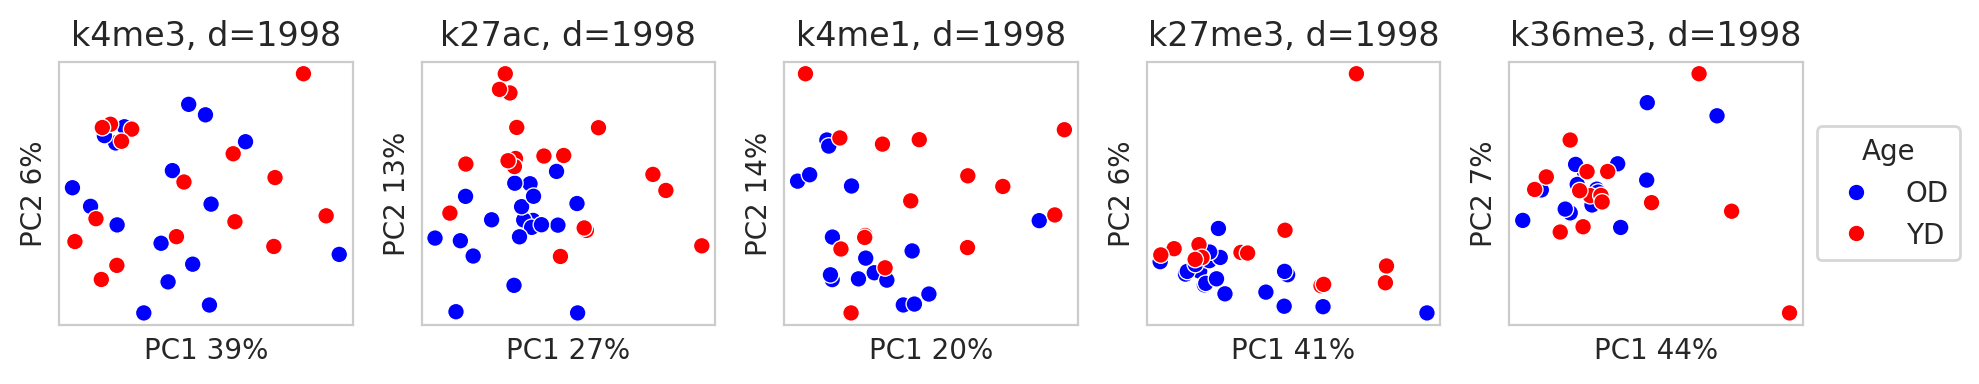

Score=coverage_norm, per1kbp=False


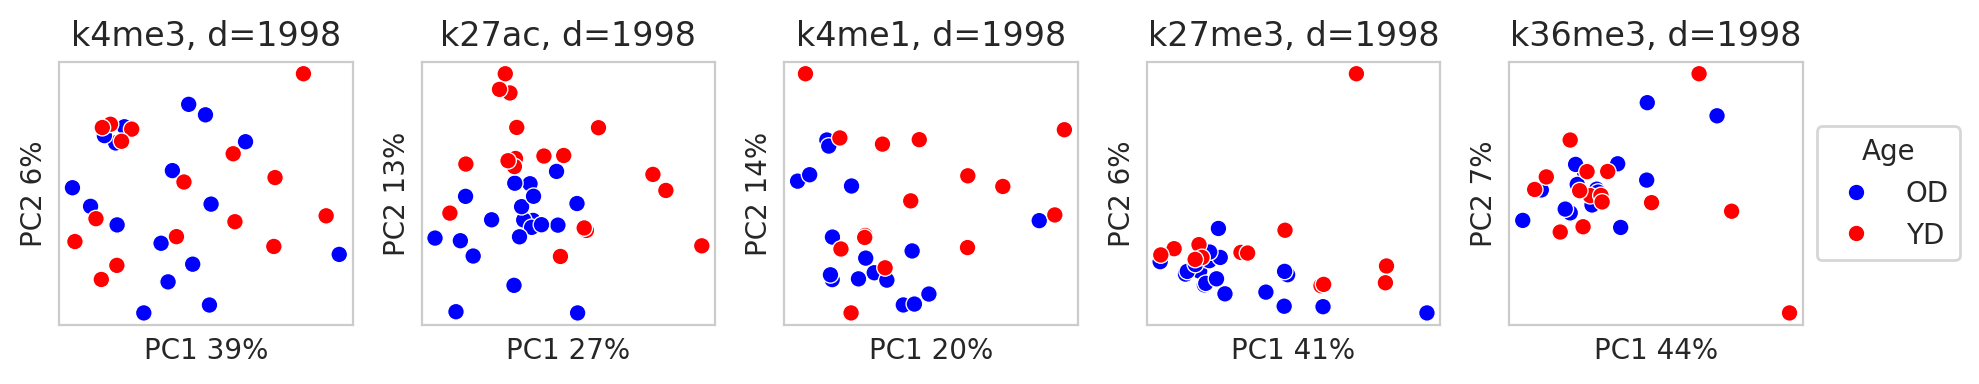

In [86]:
for (df, score), rpk in product([(union_diff_coverages_df_norm, 'coverage_norm')], [True, False]):
    if COV_TYPE == 'mean' and rpk == True:
        continue
    print(f'Score={score}, per1kbp={rpk}')
    plt.figure(figsize=(10, 3.5))
    axs = [plt.subplot(2, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        # print(m)
        ax = axs[i]
        t = df[df['modification'] == m].copy()
        if rpk:
            # Normalize to length so that difference in short regions has better contrast
            t[['chr', 'start', 'end']] = t['peak'].str.split(r'[:-]', expand=True)
            t[score] = t[score] / (t['end'].astype(int)-t['start'].astype(int)) * 1e3
        t = t[['modification', 'cell', 'replicate', 'peak', score]]
        t = pd.pivot(t, index=['modification', 'replicate', 'cell'], columns=['peak'], values=[score]).reset_index()
        show_pca(m, t[t.columns[3:]].values, t['cell'], t['replicate'], ax=ax)
        if i == len(axs) - 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
    plt.tight_layout()
    plt.show()


# Sanity check diff peak calling

In [87]:
union_diff_stats_df = diff_peak_calling(union_diff_coverages_df_norm, 'coverage_norm')
union_diff_stats_df.sort_values(by=['p_t']).head(3)

  0%|          | 0/5 [00:00<?, ?it/s]

k27ac
k27me3
k36me3
k4me1
k4me3


,modification,peak,yds_mean,ods_mean,p_t,p_mwu,od_yd_log2_fc,p_t_adj,p_mwu_adj,mp_t,mp_t_adj,mp_mwu,mp_mwu_adj
6136,k4me1,chr11:64453900-64456800,16.436191,20.338676,0.000004,0.000033,0.307350,0.008544,0.065305,5.368926,2.068330,4.485647,1.185052
793,k27ac,chr1:207996220-207997040,7.887258,10.865937,0.000010,0.000095,0.462217,0.019822,0.060929,5.003440,1.702844,4.022076,1.215172
6558,k4me1,chr18:22054400-22056370,6.568429,5.103679,0.000030,0.000249,-0.364011,0.030248,0.086403,4.518866,1.519300,3.603292,1.063472


In [ ]:
# del union_diff_coverages_df, union_diff_coverages_df_norm

In [88]:
for m in MODIFICATIONS:
    print(m, len(union_diff_stats_df[(union_diff_stats_df['modification']==m) &
                                     (union_diff_stats_df['p_t'] <= 0.05) &
                                     (np.fabs(union_diff_stats_df['od_yd_log2_fc']) >= 0)]))

k4me3 131
k27ac 959
k4me1 732
k27me3 283
k36me3 171


# Annotation

In [89]:
ts = []
for value in ['od_yd_log2_fc', 'yds_mean', 'ods_mean']:
    t = union_diff_stats_df[['modification', 'peak', value]].copy()
    t = t.pivot(index=['peak'], columns=['modification'], values=[value])
    t = t.set_axis(t.columns.map('_'.join), axis=1, copy=False)
    t = t[[f'{value}_{m}' for m in MODIFICATIONS]].copy()
    ts.append(t)
global_df = pd.concat(ts, axis=1)
global_df[['chr', 'start', 'end']] = global_df.index.to_series().str.split(r'[:-]', expand=True)
global_df['start'] = global_df['start'].astype(int)
global_df['end'] = global_df['end'].astype(int)
global_df.sort_values(by=['chr', 'start', 'end'], inplace=True)
del ts
global_df.sample(3)

,od_yd_log2_fc_k4me3,od_yd_log2_fc_k27ac,od_yd_log2_fc_k4me1,od_yd_log2_fc_k27me3,od_yd_log2_fc_k36me3,yds_mean_k4me3,yds_mean_k27ac,yds_mean_k4me1,yds_mean_k27me3,yds_mean_k36me3,ods_mean_k4me3,ods_mean_k27ac,ods_mean_k4me1,ods_mean_k27me3,ods_mean_k36me3,chr,start,end
peak,,,,,,,,,,,,,,,,,,
chr6:89637710-89638200,0.227973,-0.232918,-0.165081,-0.271430,-0.313972,0.646345,0.734173,0.445026,0.252429,1.005138,0.756992,0.624717,0.396909,0.209136,0.808557,chr6,89637710,89638200
chr15:57602030-57602400,-0.084438,0.034751,-0.272632,-0.041880,0.115783,0.648796,0.327810,1.949359,0.178516,0.111604,0.611914,0.335802,1.613696,0.173408,0.120930,chr15,57602030,57602400
chr2:132439440-132440700,-0.277757,-0.601868,0.214622,0.742971,-0.216136,11.547975,5.492614,4.293897,1.547438,0.300970,9.525604,3.619085,4.982637,2.589822,0.259095,chr2,132439440,132440700


In [90]:
CONSENSUS_PEAKS = {
    m: f'{PATH}/{m}_consensus_union25%.bed' for m in MODIFICATIONS
}
CONSENSUS_YD = {
    m: f'{PATH}/{m}_YD_consensus25%.bed' for m in MODIFICATIONS
}
GENES_TSS = f'{PATH}/gencode.v19.annotation.tss3k.tsv'
GENES_BODIES = f'{PATH}/gencode.v19.annotation.tsv'

In [91]:
tf = tempfile.mktemp()
tf2 = tempfile.mktemp()
global_df[['chr', 'start', 'end']].to_csv(tf, sep='\t', index=None, header=False)

print('Annotate at least some signal')
for m in MODIFICATIONS:
    print(m)
    ! bedtools intersect -a {tf} -b {CONSENSUS_PEAKS[m]} -u > {tf2}
    t = pd.read_csv(tf2, sep='\t', names=['chr', 'start', 'end'])
    m_signal = f'{m}_signal'
    t[m_signal] = True
    if m_signal in global_df.columns:
        global_df.drop(m_signal, axis=1, inplace=True)
    global_df = global_df.merge(t, on=['chr', 'start', 'end'], how='left')
    global_df.loc[global_df[m_signal].isnull(), m_signal] = False
    global_df[m_signal] = global_df[m_signal].astype(bool)
print(len(global_df))

print('Annotate at signal in YD')
for m in MODIFICATIONS:
    print(m)
    ! bedtools intersect -a {tf} -b {CONSENSUS_YD[m]} -u > {tf2}
    t = pd.read_csv(tf2, sep='\t', names=['chr', 'start', 'end'])
    m_yd_signal = f'{m}_YD_signal'
    t[m_yd_signal] = True
    if m_yd_signal in global_df.columns:
        global_df.drop(m_yd_signal, axis=1, inplace=True)
    global_df = global_df.merge(t, on=['chr', 'start', 'end'], how='left')
    global_df.loc[global_df[m_yd_signal].isnull(), m_yd_signal] = False
    global_df[m_yd_signal] = global_df[m_yd_signal].astype(bool)
print(len(global_df))

print('Annotate with genes and TSS')
for (name, file) in [('gene', GENES_BODIES), ('tss', GENES_TSS)]:
    print(name, file)
    ! bedtools intersect -a {tf} -b {file} -u > {tf2}
    t = pd.read_csv(tf2, sep='\t', names=['chr', 'start', 'end'])
    t[name] = True
    if name in global_df.columns:
        global_df.drop(name, axis=1, inplace=True)
    global_df = global_df.merge(t, on=['chr', 'start', 'end'], how='left')
    global_df.loc[global_df[name].isnull(), name] = False
    global_df[name] = global_df[name].astype(bool)
print(len(global_df))
global_df.sample(5)

Annotate at least some signal
k4me3
k27ac
k4me1
k27me3
k36me3
1998
Annotate at signal in YD
k4me3
k27ac
k4me1
k27me3
k36me3
1998
Annotate with genes and TSS
gene /home/jetbrains/data/2018_chipseq_y20o20/gencode.v19.annotation.tsv
tss /home/jetbrains/data/2018_chipseq_y20o20/gencode.v19.annotation.tss3k.tsv
1998


,od_yd_log2_fc_k4me3,od_yd_log2_fc_k27ac,od_yd_log2_fc_k4me1,od_yd_log2_fc_k27me3,od_yd_log2_fc_k36me3,yds_mean_k4me3,yds_mean_k27ac,yds_mean_k4me1,yds_mean_k27me3,yds_mean_k36me3,...,k4me1_signal,k27me3_signal,k36me3_signal,k4me3_YD_signal,k27ac_YD_signal,k4me1_YD_signal,k27me3_YD_signal,k36me3_YD_signal,gene,tss
1691,-0.046688,0.188791,-0.267900,-0.096511,-0.341423,1.138076,0.406147,3.128514,0.460512,0.142823,...,True,False,False,False,False,True,False,False,True,False
1397,0.017149,0.273245,0.117265,-0.237159,-0.272836,1.886623,3.862539,6.681453,0.496165,0.409689,...,True,False,False,False,True,True,False,False,True,False
398,0.014341,-0.376749,0.042705,-0.551426,-0.272665,12.642939,4.440009,7.496300,0.740387,0.763027,...,True,False,False,True,True,True,False,False,True,True
834,-0.085793,-0.278557,0.095614,-0.295305,-0.174324,13.322078,4.685326,9.349456,0.967965,0.705328,...,True,False,False,True,True,True,False,False,True,True
919,0.044482,-0.460388,-0.161693,-0.165949,-0.231156,16.151307,30.693050,47.343560,6.160080,5.239873,...,True,False,False,False,True,True,False,False,True,False


In [92]:
global_df['Location'] = 'Intergenic'
global_df.loc[global_df['gene'], 'Location'] = 'Gene'
global_df.loc[global_df['tss'], 'Location'] = 'Promoter'
global_df['Location'].unique()

array(['Promoter', 'Intergenic', 'Gene'], dtype=object)

**Enhancers**<br>
To identify young poised enhancers (H3K4me1>H3K4me3), H3K27me3+, H3K27ac−, and not within the promoter region.<br>
Active enhancers were defined as H3K27ac+, (H3K4me1 > H3K4me3), H3K27me3−, and not within the promoter region.<br>
Where H3K4me1 fold enrichment/H3K4me3 fold enrichment > 2. Promoter peaks (± 3,000 bp of TSS)


In [93]:
global_df['Enhancer'] = 'No'
global_df.loc[
    (global_df['k4me1_YD_signal']) &
    (global_df['yds_mean_k4me1'] > global_df['yds_mean_k4me3']) &
    (~global_df['tss']),
    'Enhancer'] = 'Generic'
global_df.loc[
    (global_df['k4me1_YD_signal']) &
    (global_df['yds_mean_k4me1'] > global_df['yds_mean_k4me3']) &
    (~global_df['tss']) &
    (global_df['k27me3_YD_signal']) &
    (~global_df['k27ac_YD_signal']),
    'Enhancer'] = 'Poised'
global_df.loc[
    (global_df['k4me1_YD_signal']) &
    (global_df['yds_mean_k4me1'] > global_df['yds_mean_k4me3']) &
    (~global_df['tss']) &
    (~global_df['k27me3_YD_signal']) &
    (global_df['k27ac_YD_signal']),
    'Enhancer'] = 'Active'


global_df['Enhancer'].unique()

array(['No', 'Generic', 'Active', 'Poised'], dtype=object)

**Promoters**<br>
Bivalent promoters were defined as promoter regions with overlapping enrichment for H3K4me3 and H3K27me3.<br>
Active promoters marked by the presence of both H3K4me3 and H3K27ac.<br>



In [94]:
global_df['Promoter'] = 'No'
global_df.loc[
    (global_df['k4me3_YD_signal']) &
    (global_df['tss']),
    'Promoter'] = 'Generic'
global_df.loc[
    (global_df['k4me3_YD_signal']) &
    (global_df['k27ac_YD_signal']) &
    (global_df['tss']),
    'Promoter'] = 'Active'
global_df.loc[
    (global_df['k4me3_YD_signal']) &
    (global_df['k27me3_YD_signal']) &
    (global_df['tss']),
    'Promoter'] = 'Bivalent'

global_df['Promoter'].unique()

array(['Bivalent', 'No', 'Active', 'Generic'], dtype=object)

In [95]:
# Cleanup log_fold_change, where no signal found at all
for m in MODIFICATIONS:
    global_df.loc[~(global_df[f'{m}_signal']), f'od_yd_log2_fc_{m}'] = 0

In [96]:
global_df.sample(3)

,od_yd_log2_fc_k4me3,od_yd_log2_fc_k27ac,od_yd_log2_fc_k4me1,od_yd_log2_fc_k27me3,od_yd_log2_fc_k36me3,yds_mean_k4me3,yds_mean_k27ac,yds_mean_k4me1,yds_mean_k27me3,yds_mean_k36me3,...,k4me3_YD_signal,k27ac_YD_signal,k4me1_YD_signal,k27me3_YD_signal,k36me3_YD_signal,gene,tss,Location,Enhancer,Promoter
1832,-0.000765,0.000000,0.091052,-0.295301,0.0,4.896891,1.682248,4.471495,2.792076,0.350425,...,True,False,True,True,False,True,True,Promoter,No,Bivalent
404,0.000000,0.254947,-0.080363,0.000000,0.0,2.362766,5.106967,6.481973,0.413282,0.398224,...,False,True,True,False,False,True,False,Gene,Active,No
1220,0.000000,0.297421,-0.010561,0.000000,0.0,2.474581,2.736148,6.353257,0.443495,0.403549,...,False,True,True,False,False,True,False,Gene,Active,No


# Clusters heatmap

In [97]:
from sklearn.cluster import KMeans
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(global_df[[f'od_yd_log2_fc_{m}' for m in MODIFICATIONS]])
global_df['Cluster'] = kmeans.labels_
# Sort clusters by size
csizes = [(c, sum(global_df['Cluster'] == c)) for c in range(n_clusters)]
csizes.sort(key=lambda x: x[1], reverse=True)
global_df['ClusterBySize'] = 0
for i, (c, _) in enumerate(csizes):
    global_df.loc[global_df['Cluster']==c, 'ClusterBySize'] = i
global_df.drop(['Cluster'], axis=1, inplace=True)
global_df.rename({'ClusterBySize': 'Cluster'}, axis=1, inplace=True)
global_df = global_df[
    ['chr', 'start', 'end', 'Location', 'Enhancer', 'Promoter', 'Cluster'] +
    [f'od_yd_log2_fc_{m}' for m in MODIFICATIONS] +
    [f'yds_mean_{m}' for m in MODIFICATIONS] +
    [f'ods_mean_{m}' for m in MODIFICATIONS] +
    [f'{m}_signal' for m in MODIFICATIONS]]
global_df = global_df.sort_values(by=['Cluster', 'Location', 'Enhancer', 'Promoter']).reset_index(drop=True)
global_df.sample(3)

,chr,start,end,Location,Enhancer,Promoter,Cluster,od_yd_log2_fc_k4me3,od_yd_log2_fc_k27ac,od_yd_log2_fc_k4me1,...,ods_mean_k4me3,ods_mean_k27ac,ods_mean_k4me1,ods_mean_k27me3,ods_mean_k36me3,k4me3_signal,k27ac_signal,k4me1_signal,k27me3_signal,k36me3_signal
1472,chr20,61953910,61954590,Gene,No,No,4,0.0,0.0,0.0,...,1.282902,0.384257,0.326379,0.896558,0.074988,False,False,False,True,False
1513,chr2,54650450,54653550,Intergenic,No,No,4,0.0,0.0,0.0,...,5.826498,1.757859,1.950359,3.230568,0.614135,False,False,False,True,False
1755,chr4,25152500,25152890,Gene,No,No,6,0.0,0.0,0.0,...,0.463374,0.282116,0.308873,0.115051,0.416998,False,False,False,False,True


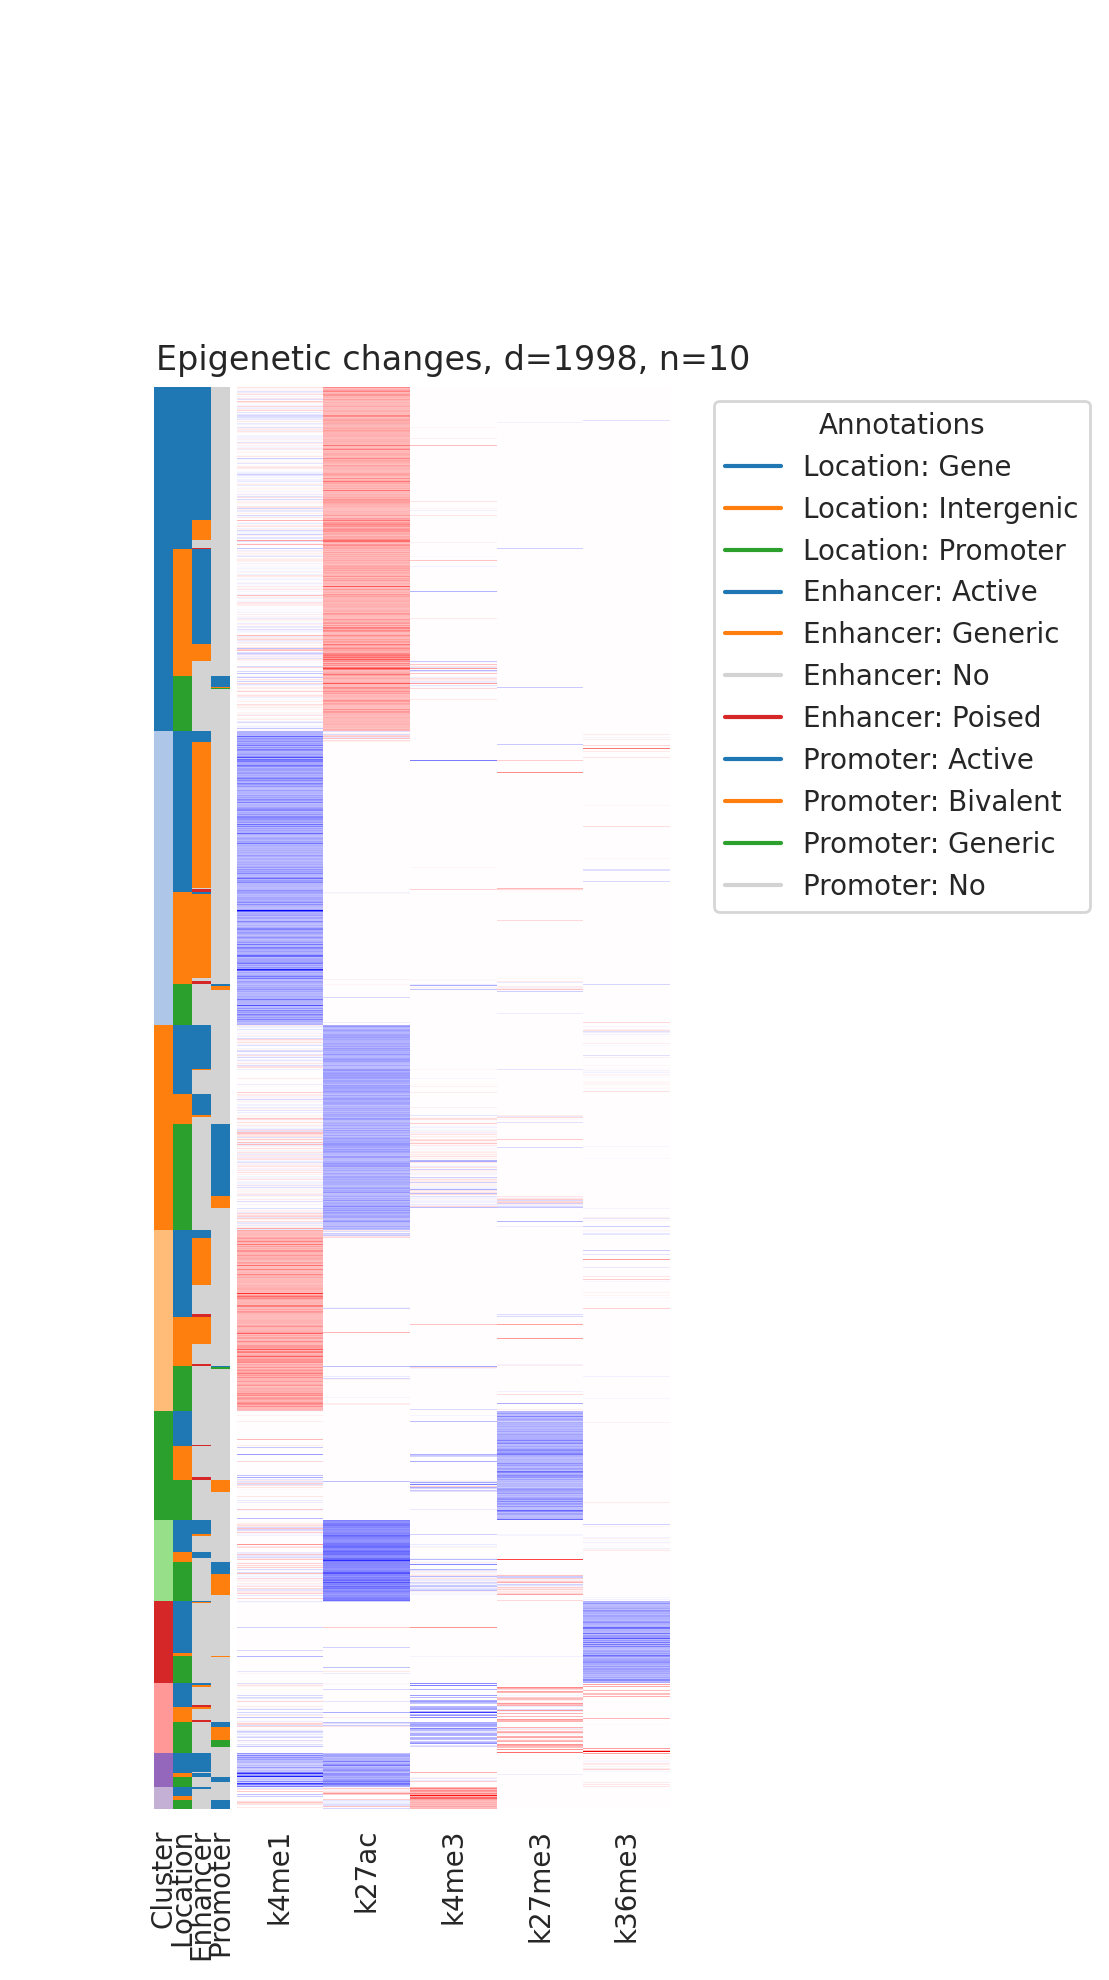

In [98]:
# Define a color palette for each annotation based on unique values
cluster_palette = sns.color_palette("tab20", len(global_df['Cluster'].unique()))
location_palette = sns.color_palette("tab10", len(global_df['Location'].unique()))
enhancer_palette = sns.color_palette("tab10", len(global_df['Enhancer'].unique()))
promoter_palette = sns.color_palette("tab10", len(global_df['Promoter'].unique()))

# Map each value to a color
cluster_colors = dict(zip(sorted(global_df['Cluster'].unique()), cluster_palette))
location_colors = dict(zip(sorted(global_df['Location'].unique()), location_palette))
enhancer_colors = dict(zip(sorted(global_df['Enhancer'].unique()), enhancer_palette))
enhancer_colors['No'] = 'LightGray'
promoter_colors = dict(zip(sorted(global_df['Promoter'].unique()), promoter_palette))
promoter_colors['No'] = 'LightGray'

# Create a color annotation matrix
row_colors = pd.DataFrame({
    'Cluster': global_df['Cluster'].map(cluster_colors),
    'Location': global_df['Location'].map(location_colors),
    'Enhancer': global_df['Enhancer'].map(enhancer_colors),
    'Promoter': global_df['Promoter'].map(promoter_colors)
}, index=global_df.index)

# Plotting with clustermap and row_colors
t = global_df[[f'od_yd_log2_fc_{m}' for m in MODIFICATIONS]].copy()
t.rename({f'od_yd_log2_fc_{m}': m for m in MODIFICATIONS}, axis=1, inplace=True)
ax = sns.clustermap(t[['k4me1', 'k27ac', 'k4me3', 'k27me3', 'k36me3']],
                    row_cluster=False, col_cluster=False, vmin=-2, vmax=2,
                    row_colors=row_colors, cmap=plt.cm.seismic, figsize=(4, 10))
# Modify y-axis ticks through ax_heatmap attribute
ax.ax_heatmap.set_yticks([])
# Remove the colorbar
ax.ax_heatmap.collections[0].colorbar.ax.remove()

# Show the legend for annotations
# for label, color in cluster_colors.items():
#     plt.plot([], [], color=color, label=f'Cluster: {label}')
for label, color in location_colors.items():
    plt.plot([], [], color=color, label=f'Location: {label}')
for label, color in enhancer_colors.items():
    plt.plot([], [], color=color, label=f'Enhancer: {label}')
for label, color in promoter_colors.items():
    plt.plot([], [], color=color, label=f'Promoter: {label}')
plt.legend(title="Annotations", bbox_to_anchor=(2, 1), loc='upper right')
plt.title(f'Epigenetic changes, d={len(global_df)}, n={n_clusters}')
plt.show()

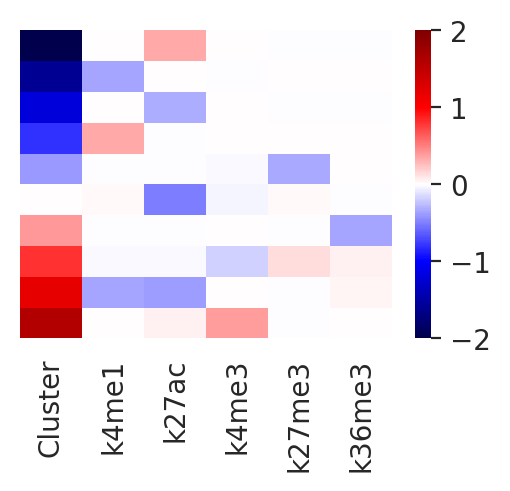

In [99]:
t2 = t.copy()
t2['Cluster'] = global_df['Cluster']
t2 = t2[['Cluster'] + ['k4me1', 'k27ac', 'k4me3', 'k27me3', 'k36me3']].groupby('Cluster').mean().reset_index()
# display(t3)
# t.drop('cluster', axis=1, inplace=True)
# hack clusters to -2..2
for c in range(n_clusters):
    t2.loc[t2['Cluster']==c, 'Cluster'] = -2 + (4 / n_clusters) * c

plt.figure(figsize=(3, 2))
ax = plt.axes()
sns.heatmap(t2,
            cmap=plt.cm.seismic,
            vmin=-2, vmax=2,
            ax=ax)
ax.set_yticklabels([])
plt.show()

In [100]:
t = global_df[
    ['chr', 'start', 'end', 'Cluster', 'Location', 'Enhancer', 'Promoter'] +
    [f'od_yd_log2_fc_{m}' for m in MODIFICATIONS] +
    [f'yds_mean_{m}' for m in MODIFICATIONS] +
    [f'ods_mean_{m}' for m in MODIFICATIONS] +
    [f'{m}_signal' for m in MODIFICATIONS]].copy()
t.sort_values(by=['chr', 'start', 'end']).to_csv(f'{PATH}/union_annotation.tsv', sep='\t', index=None)

In [101]:
! rm {PATH}/union_diff_cluster*.bed
for c in range(n_clusters):
    t = global_df[global_df['Cluster'] == c].sort_values(by=['chr', 'start', 'end'])
    path = f'{PATH}/union_diff_cluster{c}.bed'
    t[['chr', 'start', 'end'] +
      [f'od_yd_log2_fc_{m}' for m in ['k4me1', 'k27ac', 'k4me3', 'k27me3', 'k36me3']] +
       ['Cluster', 'Location', 'Enhancer', 'Promoter']
       ].to_csv(path, sep='\t', index=None, header=False)
    print(f'Cluster {c} ({len(t)}) saved to {path}')

Cluster 0 (484) saved to /home/jetbrains/data/2018_chipseq_y20o20/union_diff_cluster0.bed
Cluster 1 (413) saved to /home/jetbrains/data/2018_chipseq_y20o20/union_diff_cluster1.bed
Cluster 2 (287) saved to /home/jetbrains/data/2018_chipseq_y20o20/union_diff_cluster2.bed
Cluster 3 (254) saved to /home/jetbrains/data/2018_chipseq_y20o20/union_diff_cluster3.bed
Cluster 4 (154) saved to /home/jetbrains/data/2018_chipseq_y20o20/union_diff_cluster4.bed
Cluster 5 (114) saved to /home/jetbrains/data/2018_chipseq_y20o20/union_diff_cluster5.bed
Cluster 6 (114) saved to /home/jetbrains/data/2018_chipseq_y20o20/union_diff_cluster6.bed
Cluster 7 (99) saved to /home/jetbrains/data/2018_chipseq_y20o20/union_diff_cluster7.bed
Cluster 8 (47) saved to /home/jetbrains/data/2018_chipseq_y20o20/union_diff_cluster8.bed
Cluster 9 (32) saved to /home/jetbrains/data/2018_chipseq_y20o20/union_diff_cluster9.bed


# ChIP-seq around DMRs

In [102]:
def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

In [103]:
DMRS_PATH = f'{PATH}/mp.dmrs.ae.score_7.8.bed5_no_head.hg19.bed'
# DMRS_PEAKS = {m:DMRS_PATH for m in MODIFICATIONS}
# Pick only DMRs overlapping with modification
PEAKS_OVERLAP_DMRS = {}
ts = []

! wc -l {DMRS_PATH}
for m in MODIFICATIONS:
    consensus = CONSENSUS_PEAKS[m]
    m_dmrs_path = consensus.replace('.bed', f'_dmrs.bed')
    consensus_sorted = sorted_file(consensus)
    dmrs_sorted = sorted_file(DMRS_PATH)
    ! bedtools closest -a {consensus_sorted} -b {dmrs_sorted} -d > {m_dmrs_path}
    ! wc -l {m_dmrs_path}
    t = pd.read_csv(m_dmrs_path, sep='\t',
                    names=['chr', 'start', 'end',
                           'dmr_chr', 'dmr_start', 'dmr_end', 'name', 'score', 'p', 'meth_od_yd_diff', 'dmr_n_scores', 'dmr_n_probes', 'dmr_n_signif',
                           'd'
                           ])
    # display(t[t['p'] == '.'])
    t = t[np.fabs(t['d']) == 0].copy()
    # Single peak may overlap more than 1 DMR
    t.drop_duplicates(subset=['chr', 'start', 'end',], inplace=True)
    t['p'] = t['p'].astype(float)
    t['meth_od_yd_diff'] = t['meth_od_yd_diff'].astype(float)
    t['meth_od_yd_diff_direction'] = ['up' if mdiff > 0 else 'down' for mdiff in t['meth_od_yd_diff']]
    t['modification'] = m
    ts.append(t)
    print(len(t))
    t.to_csv(m_dmrs_path, sep='\t', index=False, header=None)
    PEAKS_OVERLAP_DMRS[m] = m_dmrs_path

peaks_overlap_dmrs_df = pd.concat(ts).reset_index(drop=True)
peaks_overlap_dmrs_df.sample(3)
# PEAKS_DMRS

6988 /home/jetbrains/data/2018_chipseq_y20o20/mp.dmrs.ae.score_7.8.bed5_no_head.hg19.bed
17414 /home/jetbrains/data/2018_chipseq_y20o20/k4me3_consensus_union25%_dmrs.bed
814
29368 /home/jetbrains/data/2018_chipseq_y20o20/k27ac_consensus_union25%_dmrs.bed
608
62141 /home/jetbrains/data/2018_chipseq_y20o20/k4me1_consensus_union25%_dmrs.bed
1491
10558 /home/jetbrains/data/2018_chipseq_y20o20/k27me3_consensus_union25%_dmrs.bed
946
21348 /home/jetbrains/data/2018_chipseq_y20o20/k36me3_consensus_union25%_dmrs.bed
170


,chr,start,end,dmr_chr,dmr_start,dmr_end,name,score,p,meth_od_yd_diff,dmr_n_scores,dmr_n_probes,dmr_n_signif,d,meth_od_yd_diff_direction,modification
3719,chr7,20811300,20846500,chr7,20824194,20824401,dmr50797,9.654474,2.215777e-10,0.021357,21,21,10,0,up,k27me3
2616,chr6,6677070,6690900,chr6,6677596,6677873,dmr47324,9.661823,2.178595e-10,-0.063005,5,5,3,0,down,k4me1
2326,chr21,43221500,43223790,chr21,43221379,43223812,dmr35248,10.173467,6.707075e-11,-0.075541,73,81,62,0,down,k4me1


In [105]:
coverages_overlap_dmrs_path = f'{PATH}/coverages_overlap_dmrs.tsv.gz'
# ! rm {coverages_overlap_dmrs_path} || true
if os.path.exists(coverages_overlap_dmrs_path):
    coverages_overlap_dmrs_df = pd.read_csv(coverages_overlap_dmrs_path, sep='\t', compression='gzip')
else:
    # coverages_overlap_dmrs_df = load_signal_peaks_profile(all_bws, PEAKS_OVERLAP_DMRS, load_control=True, peaks=100_000, covtype=COV_TYPE)
    coverages_overlap_dmrs_df = load_signal_peaks_profile(all_bws, PEAKS_OVERLAP_DMRS, load_control=False, peaks=100_000, covtype=COV_TYPE)
    coverages_overlap_dmrs_df.to_csv(coverages_overlap_dmrs_path, sep='\t', index=None, compression='gzip')
coverages_overlap_dmrs_df.sample(3)

  0%|          | 0/165 [00:00<?, ?it/s]

k4me1 YD YD15 sum /home/jetbrains/data/2018_chipseq_y20o20/k4me1_consensus_union25%_dmrs.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/YD15_k4me1_hg19.bw
k4me1 OD OD16 sum /home/jetbrains/data/2018_chipseq_y20o20/k4me1_consensus_union25%_dmrs.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/OD16_k4me1_hg19.bw
k27ac YD YD20 sum /home/jetbrains/data/2018_chipseq_y20o20/k27ac_consensus_union25%_dmrs.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/YD20_k27ac_hg19.bw
k4me1 OD OD4 sum /home/jetbrains/data/2018_chipseq_y20o20/k4me1_consensus_union25%_dmrs.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/OD4_k4me1_hg19.bw
k4me3 YD YD19 sum /home/jetbrains/data/2018_chipseq_y20o20/k4me3_consensus_union25%_dmrs.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/YD19_k4me3_hg19.bw
k36me3 YD YD6 sum /home/jetbrains/data/2018_chipseq_y20o20/k36me3_consensus_union25%_dmrs.bed /home/jetbrains/data/2018_chipseq_y20o20/bw_span/YD6_k36me3_hg19.bw
k27me3 OD OD20 sum /home/jetbrains/

,modification,cell,replicate,peak,length,coverage
35001,k4me3,YD,YD1,chr6:27598000-27600700,2700,316.515087
122152,k27me3,OD,OD18,chr13:113653270-113657090,3820,802.093357
98938,k4me1,OD,OD11,chr12:40405400-40405800,400,130.021690


In [106]:
peaks_overlap_dmrs_df['peak'] = \
    peaks_overlap_dmrs_df['chr'] + ':' + peaks_overlap_dmrs_df['start'].astype(str) + '-' + peaks_overlap_dmrs_df['end'].astype(str)

coverages_overlap_dmrs_df = coverages_overlap_dmrs_df.merge(
    peaks_overlap_dmrs_df[['modification', 'peak', 'name', 'p', 'meth_od_yd_diff', 'meth_od_yd_diff_direction']], on=['modification', 'peak'])
coverages_overlap_dmrs_df.sample(3)

,modification,cell,replicate,peak,length,coverage,name,p,meth_od_yd_diff,meth_od_yd_diff_direction
68993,k27ac,OD,OD7,chr8:42746210-42754100,7890,2872.050976,dmr54628,2.244633e-21,-0.124460,down
52105,k27ac,YD,YD18,chr12:6796100-6799570,3470,2280.179936,dmr11556,6.879470e-09,-0.061845,down
16219,k4me1,OD,OD20,chr16:24016700-24028660,11960,3384.758924,dmr20187,2.542769e-09,-0.079404,down


Average coverage


/tmp/ipykernel_3413737/2428410316.py:15: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=t, x='modification', y=value, hue='cell',


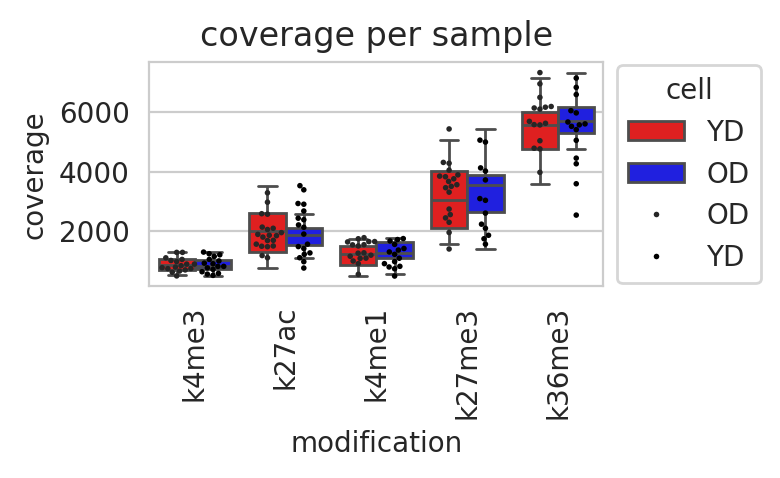

In [107]:
print('Average coverage')
plot_split(coverages_overlap_dmrs_df, 'coverage', 'coverage per sample', True)

In [108]:
# del coverages_overlap_dmrs_df_beta, dmrs_b_sums, coverages_overlap_dmrs_df_norm

In [109]:
# SPAN produces CPM normalized coverage
print('Normalize by summary in peaks')
coverages_overlap_dmrs_df_norm = coverages_overlap_dmrs_df.merge(peaks_coverages_df, on=['modification', 'cell', 'replicate'])
coverages_overlap_dmrs_df_norm['coverage_norm'] = \
    coverages_overlap_dmrs_df_norm['coverage'] / (coverages_overlap_dmrs_df_norm['peaks_coverage'] / 1e6)
coverages_overlap_dmrs_df_norm.sample(3)

Normalize by summary in peaks


,modification,cell,replicate,peak,length,coverage,name,p,meth_od_yd_diff,meth_od_yd_diff_direction,peaks_coverage,npeaks,coverage_norm
8647,k4me1,OD,OD7,chr6:2790800-2801170,10370,1167.384555,dmr47234,1.408711e-10,-0.064542,down,1.824992e+07,62050,63.966542
42038,k4me1,OD,OD12,chr12:6721100-6733500,12400,2055.543074,dmr11551,4.421073e-09,-0.045269,down,4.025992e+07,62050,51.056808
108947,k27me3,YD,YD5,chr2:87014500-87021170,6670,2713.932034,dmr29584,7.065268e-11,0.044505,up,1.831256e+07,10367,148.200588


# RPM

In [110]:
# print('Normalize by RPM')
# coverages_overlap_dmrs_df_norm = coverages_overlap_dmrs_df.merge(total_coverages_df, on=['modification', 'cell', 'replicate'])
# coverages_overlap_dmrs_df_norm['coverage_norm'] = coverages_overlap_dmrs_df_norm['coverage'] / (coverages_overlap_dmrs_df_norm['total_coverage'] / 1e6)
# coverages_overlap_dmrs_df_norm.sample(3)

In [111]:
# print('Average RPM per sample')
# plot_split(coverages_overlap_dmrs_df_norm, 'coverage_norm', 'coverage_norm per sample', True)

# Beta

In [112]:
# t = df_betas.groupby(['modification', 'cell', 'replicate']).mean().reset_index()
# coverages_overlap_dmrs_df_beta = coverages_overlap_dmrs_df.merge(t, on=['modification', 'cell', 'replicate'])
# coverages_overlap_dmrs_df_beta['coverage_b'] = np.clip(
#     coverages_overlap_dmrs_df_beta['coverage'] - coverages_overlap_dmrs_df_beta['b'] * coverages_overlap_dmrs_df_beta['input_coverage'] *
#     (coverages_overlap_dmrs_df_beta['coverage_sum'] / coverages_overlap_dmrs_df_beta['input_coverage_sum']),
#     a_min=0.0, a_max=None
# )
#
# dmrs_b_sums = coverages_overlap_dmrs_df_beta[['modification', 'cell', 'replicate', 'coverage_b']].groupby(
#     ['modification', 'cell', 'replicate']).sum().reset_index()
# dmrs_b_sums.rename({'coverage_b': 'coverage_b_sum'}, axis=1, inplace=True)
#
# print('Normalize by b-coverage summary in sample')
# coverages_overlap_dmrs_df_norm = coverages_overlap_dmrs_df_beta.merge(dmrs_b_sums, on=['modification', 'cell', 'replicate'])
# coverages_overlap_dmrs_df_norm['coverage_norm'] = \
#     coverages_overlap_dmrs_df_norm['coverage_b'] / (coverages_overlap_dmrs_df_norm['coverage_b_sum'] / coverages_overlap_dmrs_df_norm['coverage_b_sum'].max())
#
# coverages_overlap_dmrs_df_norm.sample(3)

In [113]:
# print('Average normalized b coverage')
# plot_split(coverages_overlap_dmrs_df_beta, 'coverage_b', 'coverage_b per sample', True)

In [114]:
# print('Average normalized coverage')
# plot_split(coverages_overlap_dmrs_df_norm, 'coverage_norm', 'coverage_norm per sample', True)

# PCA around DMRs

Score=coverage, per1kbp=False meth_diff: None


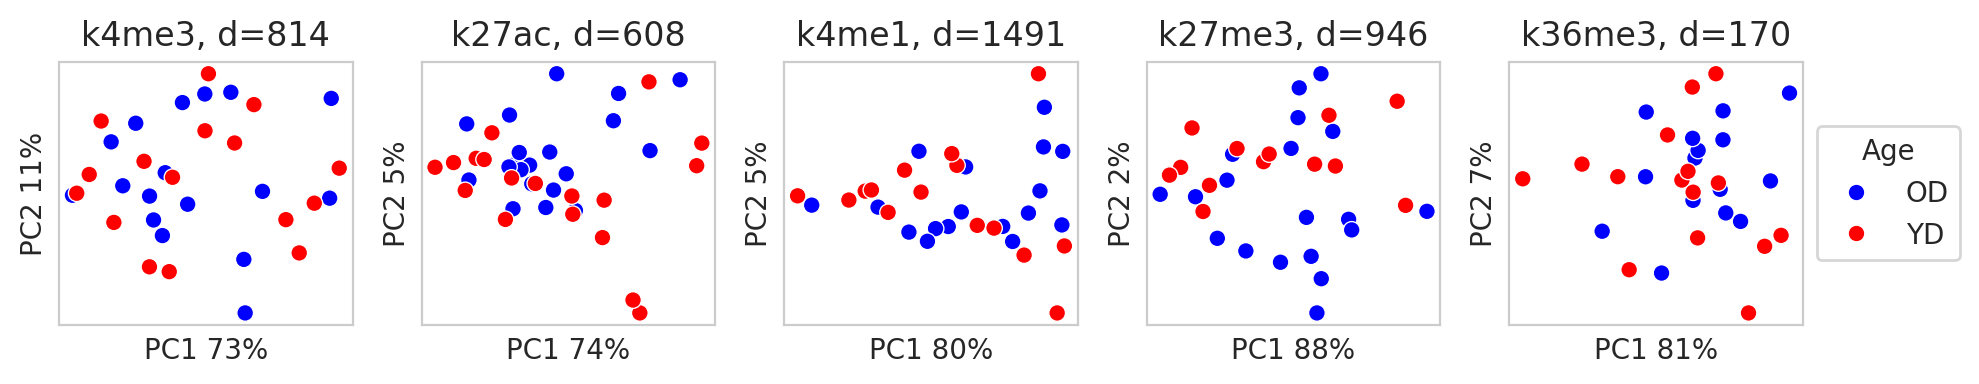

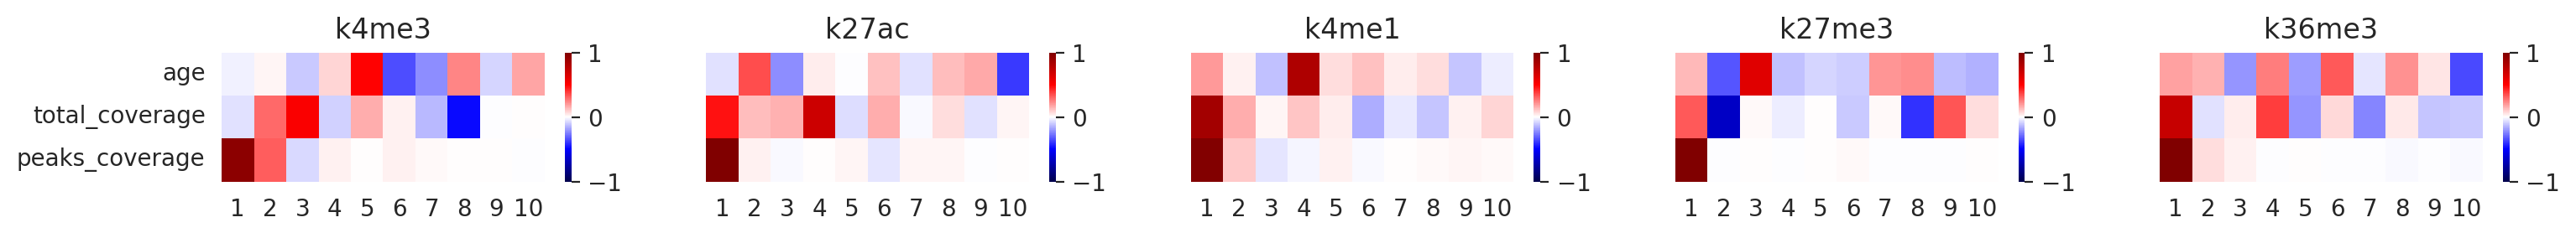

Score=coverage_norm, per1kbp=False meth_diff: None


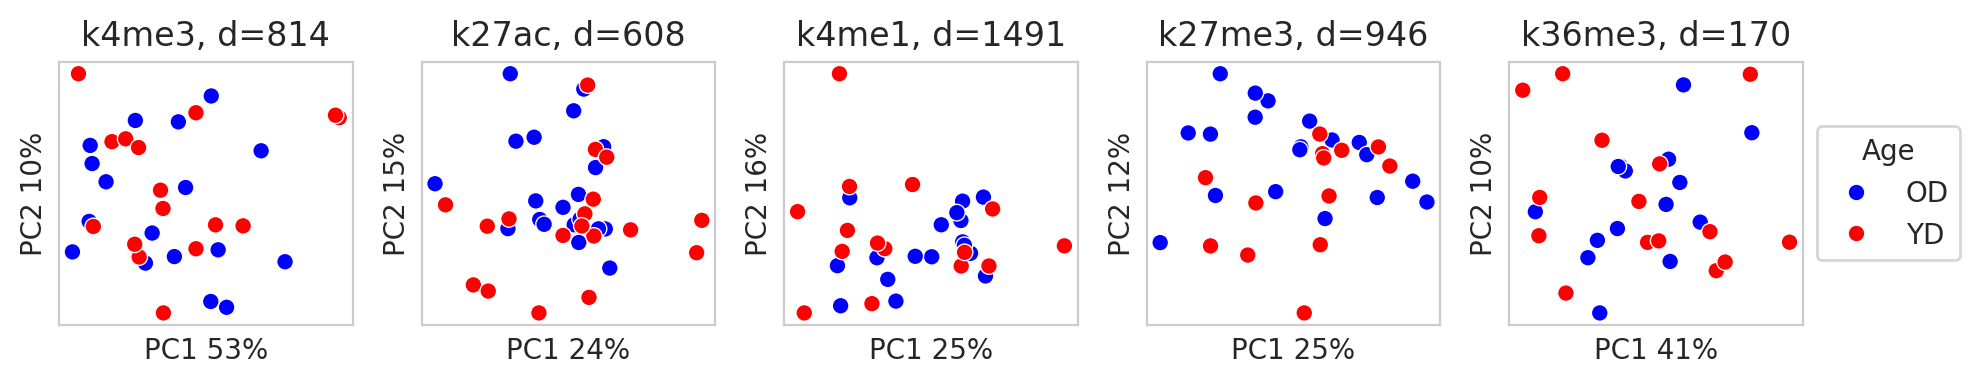

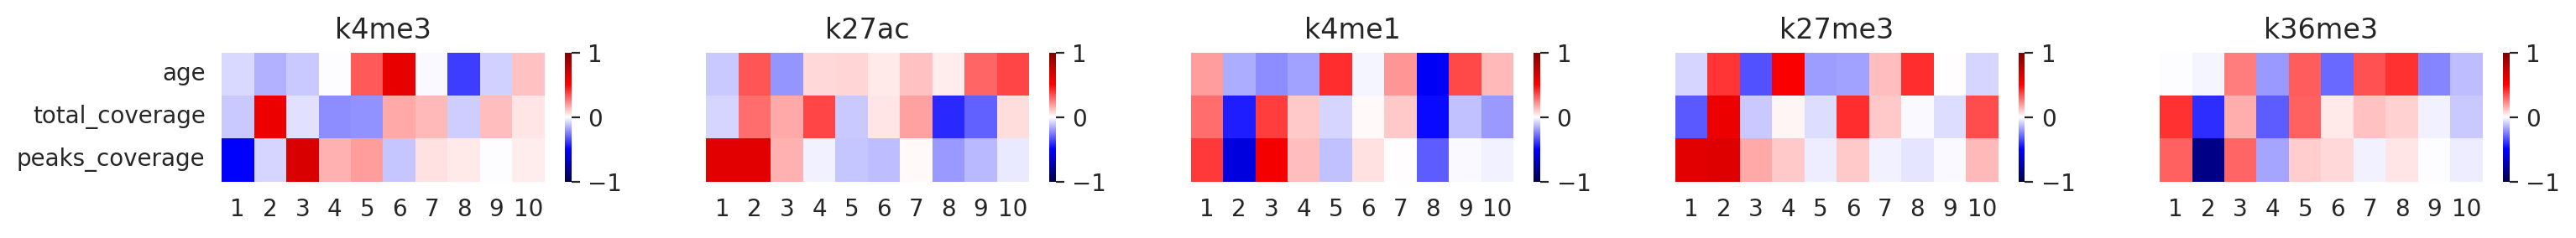

In [115]:
for (df, score), rpk, direction in product([(coverages_overlap_dmrs_df, 'coverage'),
                                            # (coverages_overlap_dmrs_df_beta, 'coverage_b'),
                                            (coverages_overlap_dmrs_df_norm, 'coverage_norm')
], [False],
                                           # ['up', 'down', None]
                                           [None]
                                           ):
    print(f'Score={score}, per1kbp={rpk} meth_diff: {direction}')
    ts = {}
    plt.figure(figsize=(10, 3.5))
    axs = [plt.subplot(2, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        # print(m)
        ax = axs[i]
        t = df[df['modification'] == m]
        if direction is not None:
            t = t[t['meth_od_yd_diff_direction'] == direction]
        t = t[['modification', 'cell', 'replicate', 'peak', score]].copy()
        if len(t) < 20:
            continue
        if rpk:
            # Normalize to length so that difference in short regions has better contrast
            t[['chr', 'start', 'end']] = t['peak'].str.split(r'[:-]', expand=True)
            t[score] = t[score] / (t['end'].astype(int)-t['start'].astype(int)) * 1e3
        t = pd.pivot(t, index=['modification', 'replicate', 'cell'], columns=['peak'], values=[score]).reset_index()
        result_pca = show_pca(m, t[t.columns[3:]].values, t['cell'], t['replicate'], 10, ax=ax)
        t = t.set_axis(t.columns.map('_'.join), axis=1, copy=False)
        t.rename({'modification_': 'modification', 'cell_': 'cell', 'replicate_': 'replicate'}, axis=1, inplace=True)
        t = t.merge(total_coverages_df, on=['modification', 'cell', 'replicate'])
        t = t.merge(peaks_coverages_df, on=['modification', 'cell', 'replicate'])
        t['age'] = [1 if a[0] == 'O' else -1 for a in t['cell']]
        n_components = result_pca.shape[1]
        cors = {v: [pearsonr(t[v], result_pca[:, c])[0] for c in range(n_components)] for v in ['age', 'total_coverage', 'peaks_coverage']}
        # display(cors)
        ts[m] = pd.DataFrame(cors, index=[c + 1 for c in range(n_components)])
        if i == len(axs) - 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(18, 1))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.heatmap(ts[m].T, cmap=plt.cm.seismic, vmin=-1, vmax=1, ax=ax)
        ax.set_title(m)
        if i > 0:
            ax.set_yticklabels([])
    plt.show()


# PCA on age correlated PCs

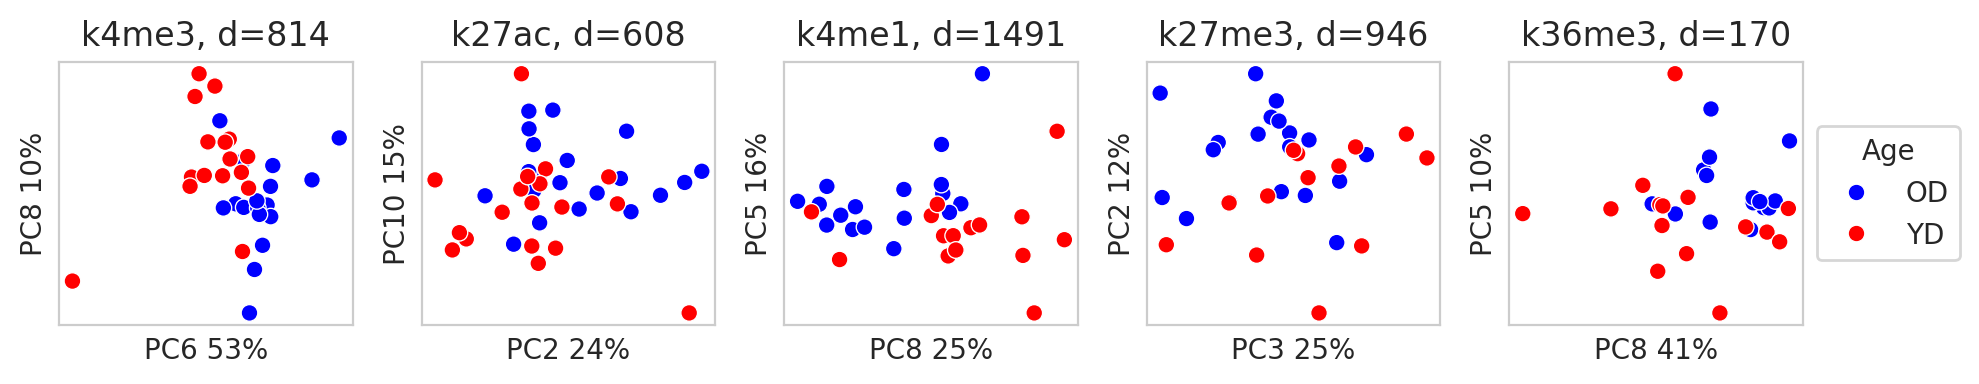

In [117]:
# df, score = coverages_overlap_dmrs_df, 'coverage'
# components = [('k4me3', 5, 6), ('k27ac', 2, 10), ('k4me1', 4, 1), ('k27me3', 3, 2), ('k36me3', 6, 10)]
df, score = coverages_overlap_dmrs_df_norm, 'coverage_norm'
components = [('k4me3', 6, 8), ('k27ac', 2, 10), ('k4me1', 8, 5), ('k27me3', 3, 2), ('k36me3', 8, 5)]
plt.figure(figsize=(10, 3.5))
axs = [plt.subplot(2, 5, i + 1) for i in range(5)]
for i, (m, pcx, pcy) in enumerate(components):
    ax = axs[i]
    t = df[df['modification'] == m]
    t = pd.pivot(t, index=['modification', 'replicate', 'cell'], columns=['peak'], values=[score]).reset_index()
    show_pca(m, t[t.columns[3:]].values, t['cell'], t['replicate'], 10, pcx, pcy, ax=ax)
    if i == len(axs) - 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
plt.tight_layout()
plt.show()


# K4me1 / K27me3 diff around DMRs

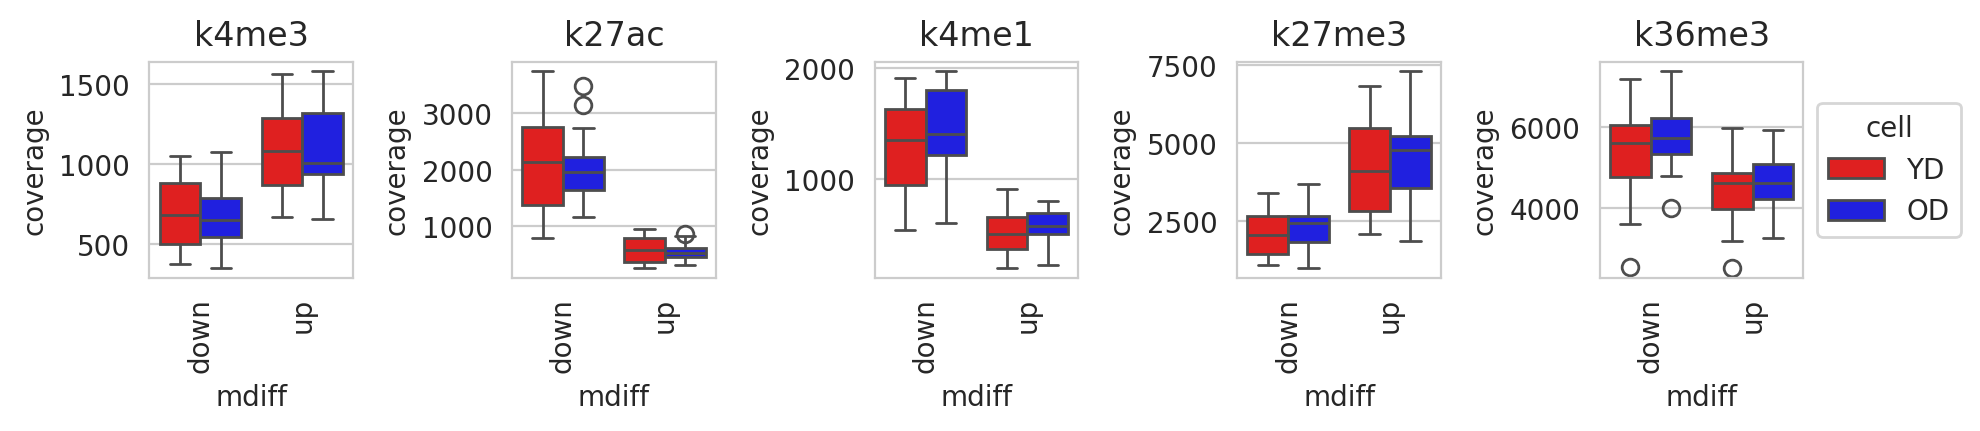

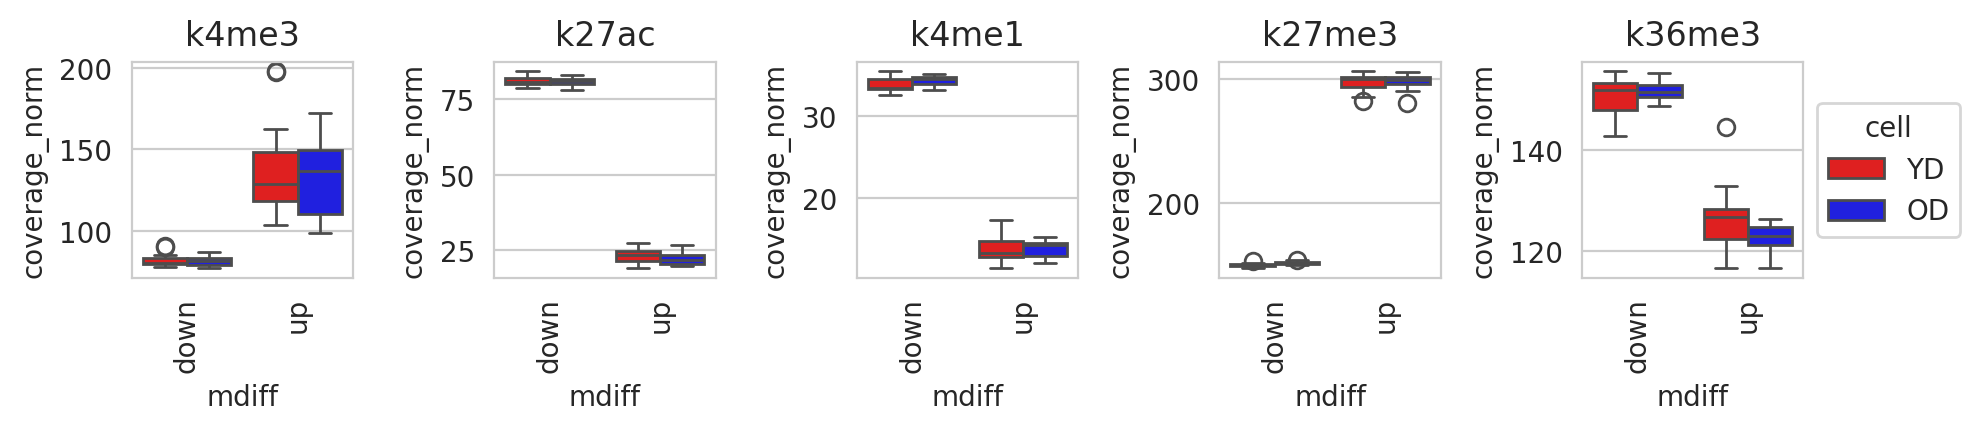

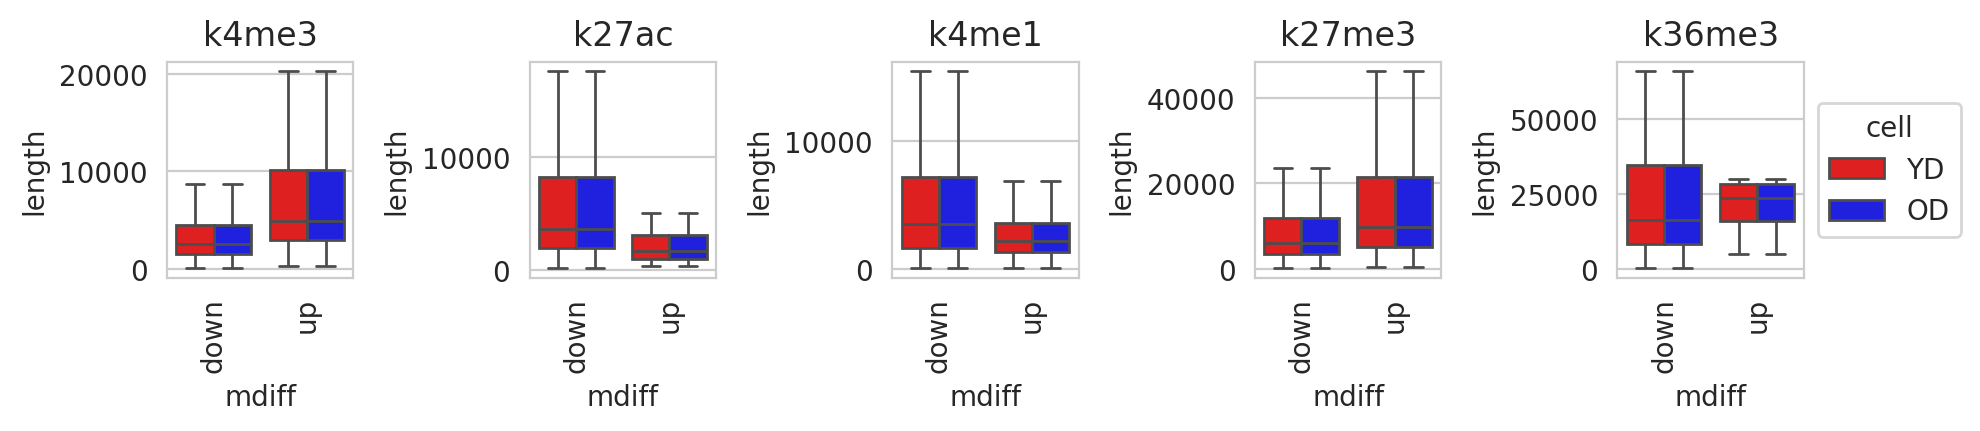

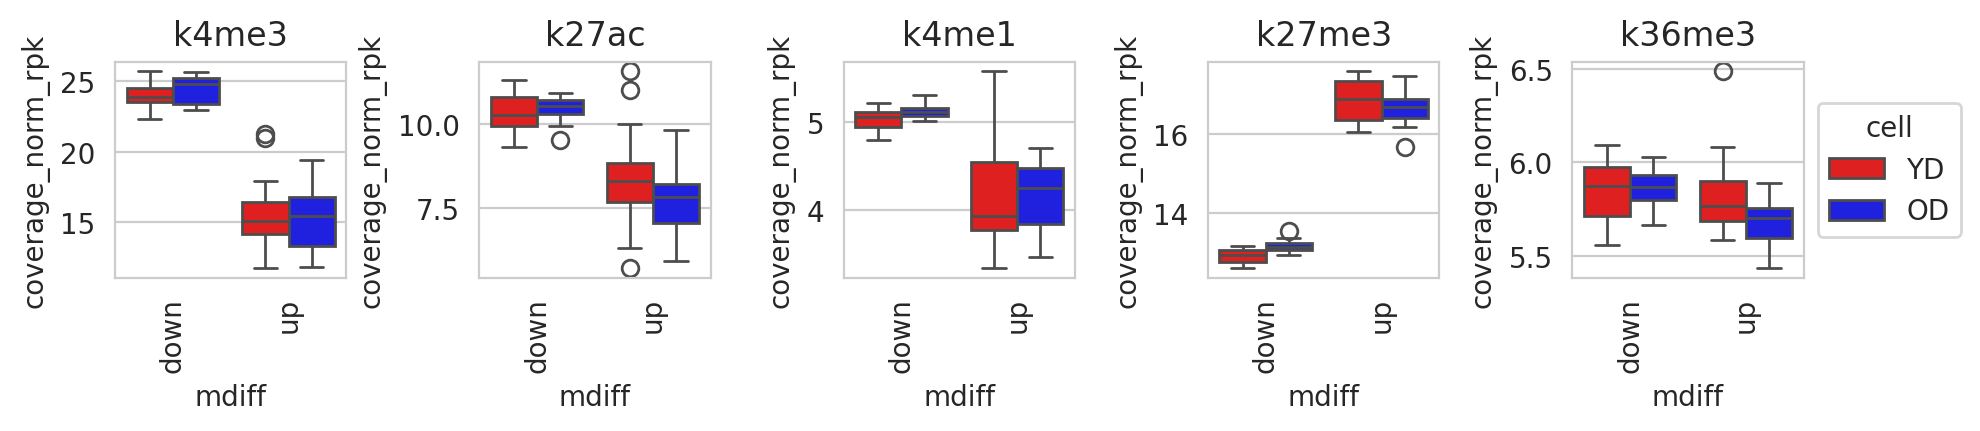

In [118]:
# Normalize to length so that difference in short regions has better contrast
coverages_overlap_dmrs_df_norm[['chr', 'start', 'end']] = coverages_overlap_dmrs_df_norm['peak'].str.split(r'[:-]', expand=True)
coverages_overlap_dmrs_df_norm['length'] = coverages_overlap_dmrs_df_norm['end'].astype(int)-coverages_overlap_dmrs_df_norm['start'].astype(int)
coverages_overlap_dmrs_df_norm['coverage_norm_rpk'] = coverages_overlap_dmrs_df_norm['coverage_norm'] / coverages_overlap_dmrs_df_norm['length'] * 1e3

for df, score in [
    (coverages_overlap_dmrs_df, 'coverage'),
    (coverages_overlap_dmrs_df_norm, 'coverage_norm'),
    (coverages_overlap_dmrs_df_norm, 'length'),
    (coverages_overlap_dmrs_df_norm, 'coverage_norm_rpk')
]:
    plt.figure(figsize=(10, 3.5))
    axs = [plt.subplot(2, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        t = df[df['modification'] == m]
        if score != 'length':
            t = t[['cell', 'replicate', 'meth_od_yd_diff_direction', score]].groupby(
                ['cell', 'replicate', 'meth_od_yd_diff_direction'], as_index=False).mean()
        sns.boxplot(t, x='meth_od_yd_diff_direction', y=score, hue='cell',
                    showfliers=score!='length',
                    hue_order=['YD', 'OD'], palette={'YD': 'red', 'OD': 'blue'},
                    ax=ax)
        ax.set_title(m)
        ax.set_xlabel('mdiff')
        ax.xaxis.set_tick_params(rotation=90)
        if i == len(axs) - 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
    plt.tight_layout()
    plt.show()


# Diff

In [ ]:
dmrs_diff_stats_df = diff_peak_calling(coverages_overlap_dmrs_df_norm, 'coverage_norm')
dmrs_diff_stats_df.sort_values(by='p_t').head(10)

In [ ]:
dmrs_diff_stats_df[['chr', 'start', 'end']] = dmrs_diff_stats_df['peak'].str.split(r'[:-]', expand=True)
dmrs_diff_stats_df = dmrs_diff_stats_df.merge(
    peaks_overlap_dmrs_df[['modification', 'peak', 'name', 'p', 'meth_od_yd_diff', 'meth_od_yd_diff_direction']], on=['modification', 'peak'])
dmrs_diff_stats_df.sample(3)

# Deseq2

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats


In [ ]:
# print('DeSeq2')
# for (df, score), rpk in product([ (coverages_overlap_dmrs_df, 'coverage'),
#                                  # (coverages_overlap_dmrs_df_beta, 'coverage_b'),
#                                  # (coverages_overlap_dmrs_df_norm, 'coverage_norm')
# ], [False, True]):
#
#     plt.figure(figsize=(10, 3.5))
#     axs = [plt.subplot(2, 5, i + 1) for i in range(5)]
#     for i, m in enumerate(MODIFICATIONS):
#         print(m)
#         ax = axs[i]
#         t = df[
#             (df['modification'] == m)
#             # & (df['meth_od_yd_diff'] > 0)
#             # & (df['p'] < 0.05)
#             ][['modification', 'cell', 'replicate', 'peak', score]].copy()
#         if rpk:
#             # Normalize to length so that difference in short regions has better contrast
#             t[['chr', 'start', 'end']] = t['peak'].str.split(r'[:-]', expand=True)
#             t[score] = t[score] / (t['end'].astype(int)-t['start'].astype(int)) * 1e3
#         if len(t) < 20:
#             continue
#         counts = pd.pivot(t, index=['modification', 'replicate', 'cell'], columns=['peak'], values=[score]).reset_index()
#         counts.set_index('replicate', inplace=True)
#         counts = counts.set_axis(counts.columns.map('_'.join), axis=1, copy=False)
#         metadata = counts[['cell_']].copy()
#         metadata.rename({'cell_': 'cell' }, axis=1, inplace=True)
#         counts.drop(['modification_', 'cell_'], axis=1, inplace=True)
#         counts.fillna(0, inplace=True)
#         # display(counts.head(3))
#         dds = DeseqDataSet(counts=counts.astype(int), metadata=metadata, design_factors='cell')
#         dds.deseq2()
#         stat_res = DeseqStats(dds, contrast=('cell', 'OD', 'YD'))
#         # display(dds.layers["normed_counts"])
#         print(f'Score={score}, per1kbp={rpk}')
#         show_pca(m, dds.layers["normed_counts"], metadata['cell'], metadata.index, 10, ax=ax)
#         if i == len(axs) - 1:
#             sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#         else:
#             ax.legend().set_visible(False)
#     plt.tight_layout()
#     plt.show()


# TMM

In [ ]:
# for m in MODIFICATIONS:
#     t = total_coverages_df[total_coverages_df['modification'] == m][['replicate', 'total_coverage']].copy()
#     t.set_index('replicate', inplace=True)
#     t = t.astype(int)
#     t.to_csv(f'{PATH}/{m}_libraries.tsv', sep='\t', header=None)

In [ ]:
# for m in MODIFICATIONS:
#     print(m)
#     ! rm {PATH}/{m}_dmrs_tmm.tsv || true
#     t = coverages_overlap_dmrs_df[
#         (coverages_overlap_dmrs_df['modification'] == m) &
#         # (coverages_overlap_dmrs_df['meth_od_yd_diff'] > 0) &
#         (coverages_overlap_dmrs_df['p'] < 0.05)
#         ][['modification', 'cell', 'replicate', 'peak', 'coverage']].copy()
#     # Outlier based on PCA in all DMRs
#     if m == 'k27me3':
#         t = t[~(t['replicate'].isin(['YD18', 'YD20', 'OD16', 'OD18', 'YD15']))]
#     if len(t) < 30:
#         continue
#     t = pd.pivot(t, index=['modification', 'replicate', 'cell'], columns=['peak'], values=['coverage']).reset_index()
#     replicates = list(t['replicate'])
#     t = t[t.columns[3:]].values.T
#     t = np.log1p(t)
#     t = pd.DataFrame(t, columns=replicates)
#     t.to_csv(f'{PATH}/{m}_dmrs.tsv', sep='\t', index=False)
#     ! Rscript {PATH}/tmm.R {PATH}/{m}_dmrs.tsv {PATH}/{m}_libraries.tsv {PATH}/{m}_dmrs_tmm.tsv

In [ ]:
# plt.figure(figsize=(10, 3.5))
# axs = [plt.subplot(2, 5, i + 1) for i in range(5)]
# for i, m in enumerate(MODIFICATIONS):
#     # print(m)
#     ax = axs[i]
#     if os.path.exists(f'{PATH}/{m}_dmrs_tmm.tsv'):
#         t = pd.read_csv(f'{PATH}/{m}_dmrs_tmm.tsv', sep='\t')
#         show_pca(m, t.T.values, [c[:2] for c in t.columns], t.columns, 10, ax=ax)
#     if i == len(axs) - 1:
#         sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#     else:
#         ax.legend().set_visible(False)
# plt.tight_layout()
# plt.show()


# Volcanos

In [ ]:
dmrs_diff_stats_df['meth_diff_color'] = ['red' if mdiff < 0 else 'blue' for mdiff in dmrs_diff_stats_df['meth_od_yd_diff']]
dmrs_diff_stats_df['chipseq_diff_color'] = 'lightgrey'
dmrs_diff_stats_df.loc[
    (dmrs_diff_stats_df['p_t'] <= 0.05) &
    (dmrs_diff_stats_df['od_yd_log2_fc'] >= 0.25),'chipseq_diff_color'] = 'blue'
dmrs_diff_stats_df.loc[
    (dmrs_diff_stats_df['p_t'] <= 0.05) &
    (dmrs_diff_stats_df['od_yd_log2_fc'] <= -0.25),'chipseq_diff_color'] = 'red'


## H3K4me3

In [ ]:
t = dmrs_diff_stats_df[dmrs_diff_stats_df['modification'] == 'k4me3']
fig = render_interactive_volcano(
    t, 
    f'H3K4me3 on DMRs t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['meth_diff_color']
)
fig.show()

In [ ]:
t = dmrs_diff_stats_df[(dmrs_diff_stats_df['modification'] == 'k4me3') & (dmrs_diff_stats_df['meth_od_yd_diff'] > 0)]
fig = render_interactive_volcano(
    t,
    f'H3K4me3 on DMRs meth diff > 0 t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['chipseq_diff_color']
)
fig.show()

In [ ]:
t = dmrs_diff_stats_df[(dmrs_diff_stats_df['modification'] == 'k4me3') & (dmrs_diff_stats_df['meth_od_yd_diff'] < 0)]
fig = render_interactive_volcano(
    t,
    f'H3K4me3 on DMRs meth diff < 0 t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['chipseq_diff_color']
)
fig.show()

## H3K27ac

In [ ]:
t = dmrs_diff_stats_df[dmrs_diff_stats_df['modification'] == 'k27ac']
fig = render_interactive_volcano(
    t, 
    f'H3K27ac on DMRs t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['meth_diff_color']
)
fig.show()

In [ ]:
t = dmrs_diff_stats_df[(dmrs_diff_stats_df['modification'] == 'k27ac') &
                       (dmrs_diff_stats_df['meth_od_yd_diff'] > 0) &
                       (dmrs_diff_stats_df['p'] < 0.05)
]
fig = render_interactive_volcano(
    t,
    f'H3K27ac on DMRs meth diff > 0 t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['chipseq_diff_color']
)
fig.show()

In [ ]:
t = dmrs_diff_stats_df[(dmrs_diff_stats_df['modification']=='k27ac') &
                       (dmrs_diff_stats_df['meth_od_yd_diff'] < 0)].sort_values(by=['mp_t'], ascending=False).head(10)
display(t)

In [ ]:
t = dmrs_diff_stats_df[(dmrs_diff_stats_df['modification'] == 'k27ac') & (dmrs_diff_stats_df['meth_od_yd_diff'] < 0)]
fig = render_interactive_volcano(
    t,
    f'H3K27ac on DMRs meth diff < 0 t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['chipseq_diff_color']
)
fig.show()

In [ ]:
t = dmrs_diff_stats_df[(dmrs_diff_stats_df['modification']=='k27ac') & 
                       (dmrs_diff_stats_df['meth_od_yd_diff'] > 0)].sort_values(by=['mp_t'], ascending=False).head(10)
display(t)

## H3K4me1

In [ ]:
t = dmrs_diff_stats_df[dmrs_diff_stats_df['modification'] == 'k4me1']
fig = render_interactive_volcano(
    t, 
    f'H3K4me1 on DMRs t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['meth_diff_color']
)
fig.show()

In [ ]:
t = dmrs_diff_stats_df[(dmrs_diff_stats_df['modification'] == 'k4me1') & (dmrs_diff_stats_df['meth_od_yd_diff'] > 0)]
fig = render_interactive_volcano(
    t,
    f'H3K4me1 on DMRs meth diff > 0 t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['chipseq_diff_color']
)
fig.show()

In [ ]:
t = dmrs_diff_stats_df[(dmrs_diff_stats_df['modification']=='k4me1') &
                       (dmrs_diff_stats_df['meth_od_yd_diff'] > 0)].sort_values(by=['mp_t'], ascending=False).head(10)
display(t)

In [ ]:
t = dmrs_diff_stats_df[(dmrs_diff_stats_df['modification'] == 'k4me1') & (dmrs_diff_stats_df['meth_od_yd_diff'] < 0)]
fig = render_interactive_volcano(
    t,
    f'H3K4me1 on DMRs meth diff < 0 t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['chipseq_diff_color']
)
fig.show()

In [ ]:
t = dmrs_diff_stats_df[(dmrs_diff_stats_df['modification']=='k4me1') &
                       (dmrs_diff_stats_df['meth_od_yd_diff'] < 0)].sort_values(by=['mp_t'], ascending=False).head(10)
display(t)

## H3K27me3

In [ ]:
t = dmrs_diff_stats_df[dmrs_diff_stats_df['modification'] == 'k27me3']
fig = render_interactive_volcano(
    t, 
    f'H3K27me3 on DMRs t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['meth_diff_color']
)
fig.show()

In [ ]:
t = dmrs_diff_stats_df[(dmrs_diff_stats_df['modification'] == 'k27me3') & (dmrs_diff_stats_df['meth_od_yd_diff'] > 0)]
fig = render_interactive_volcano(
    t,
    f'H3K27me3 on DMRs meth diff > 0 t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['chipseq_diff_color']
)
fig.show()

In [ ]:
t = dmrs_diff_stats_df[(dmrs_diff_stats_df['modification'] == 'k27me3') & (dmrs_diff_stats_df['meth_od_yd_diff'] < 0)]
fig = render_interactive_volcano(
    t,
    f'H3K27me3 on DMRs meth diff < 0 t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['chipseq_diff_color']
)
fig.show()

## H3K36me3

In [ ]:
t = dmrs_diff_stats_df[dmrs_diff_stats_df['modification'] == 'k36me3']
fig = render_interactive_volcano(
    t, 
    f'H3K36me3 on DMRs t-test n={len(t)}', 'mp_t',
    abs_log2_fc_thr=0.25,
    colors=t['meth_diff_color']
)
fig.show()

# GSEA vs DMRs

In [ ]:
# ! mamba install -y -c bioconda gseapy

In [ ]:
from gseapy.plot import gseaplot
import gseapy as gp

## Individual rankings

In [ ]:
rows = []

for m in MODIFICATIONS:
    print(m)
    tm = dmrs_diff_stats_df[dmrs_diff_stats_df['modification'] == m].copy()
    tm.sort_values(by=['meth_od_yd_diff'], inplace=True)
    # tm['Rank'] = np.sign(tm['meth_od_yd_diff']) * -np.log10(tm['p'])
    tm['Rank'] = tm['meth_od_yd_diff']
    tm['Gene'] = [f'gene_{i}' for i in range(len(tm))]
    dmrs_m_ranking = tm
    # display(dmrs_m_ranking.head(3))
    t = dmrs_diff_stats_df[
        (dmrs_diff_stats_df['modification']==m) &
        (dmrs_diff_stats_df['p_t'] < 0.05)
        ].copy()
    t = t.merge(dmrs_m_ranking[['peak', 'Gene']], on='peak')  # Add Gene
    # display(t.head(3))
    diff_chipseq_sets = {}
    up = list(t[t['od_yd_log2_fc'] > 0.25]['Gene'])
    if len(up) >= 10:
        diff_chipseq_sets[f'{m} up od vs yd'] = up
    down = list(t[t['od_yd_log2_fc'] < 0.25]['Gene'])
    if len(down) >= 10:
        diff_chipseq_sets[f'{m} down od vs yd'] = down
    if len(diff_chipseq_sets) == 0:
        continue
    pre_res = gp.prerank(rnk=dmrs_m_ranking[['Gene', 'Rank']], gene_sets=diff_chipseq_sets, seed=42, min_size=10)
    for term in pre_res.results.keys():
        rows.append((term, pre_res.results[term]['fdr'], pre_res.results[term]['es'], pre_res.results[term]['nes']))
    for term in pre_res.results.keys():
        if pre_res.results[term]['fdr'] < 0.05:
            pre_res.plot(terms=term)
            # gseaplot(term=name, **pre_res.results[name], figsize=(7, 3), color='red' if 'down' in name else 'blue')
            plt.show()

dmrs_gsea_df = pd.DataFrame(rows, columns=['term', 'fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop=True)
del rows
dmrs_gsea_df

## Single ranking

In [ ]:
# Use single ranking based on differential DMRs
# dmr_chr dmr_start dmr_end dmr_name -log10(mlevel~age+sex+bmi (>=60x)) pval-Age mdiff dmr_n_scores dmr_n_probes dmr_n_signif
dmrs_ranking_df = pd.read_csv(
    DMRS_PATH, sep='\t',
    names=['chr', 'start', 'end', 'name', 'score', 'p', 'meth_od_yd_diff', 'dmr_n_scores', 'dmr_n_probes', 'dmr_n_signif']
)
dmrs_ranking_df['peak'] = dmrs_ranking_df['chr'] + ':' + dmrs_ranking_df['start'].astype(str) + '-' + dmrs_ranking_df['end'].astype(str)
dmrs_ranking_df.sort_values(by=['meth_od_yd_diff'], inplace=True)

# dmrs_ranking_df['Rank'] = np.sign(dmrs_ranking_df['meth_od_yd_diff']) * -np.log10(dmrs_ranking_df['p'])
dmrs_ranking_df['Rank'] = dmrs_ranking_df['meth_od_yd_diff']
dmrs_ranking_df['Gene'] = [f'gene_{i}' for i in range(len(dmrs_df))]

dmrs_ranking_df.sample(3)

In [ ]:
DIFF_CHIPSEQ_SETS = {}

for m in MODIFICATIONS:
    print(m)
    # display(dmrs_m_ranking.head(3))
    t = dmrs_diff_stats_df[
        (dmrs_diff_stats_df['modification'] == m) &
        (dmrs_diff_stats_df['p_t'] < 0.05)
        ].copy()
    t = t.merge(dmrs_ranking_df[['peak', 'Gene']], on='peak')  # Add Gene
    # display(t.head(3))
    DIFF_CHIPSEQ_SETS[f'{m} up od vs yd'] = list(t[t['od_yd_log2_fc'] > 0.25]['Gene'])
    DIFF_CHIPSEQ_SETS[f'{m} down od vs yd'] = list(t[t['od_yd_log2_fc'] < 0.25]['Gene'])


In [ ]:
pre_res = gp.prerank(rnk=dmrs_ranking_df[['Gene', 'Rank']], gene_sets=DIFF_CHIPSEQ_SETS, seed=42, min_size=10)
rows = []
for term in pre_res.results.keys():
    rows.append((term, pre_res.results[term]['fdr'], pre_res.results[term]['es'], pre_res.results[term]['nes']))
dmrs_gsea_df = pd.DataFrame(rows, columns=['term', 'fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop=True)
del rows
dmrs_gsea_df


In [ ]:
for name in dmrs_gsea_df[dmrs_gsea_df['fdr'] < 0.05]['term']:
    pre_res.plot(terms=name)
    # gseaplot(term=name, **pre_res.results[name], figsize=(7, 3), color='red' if 'down' in name else 'blue')
    plt.show()

# END